<p style="padding-bottom: 10px;
          margin-bottom: 10px;
          font-size: 50px;
          font-weight: bold;
          color: orange; 
          text-align: center;
          font-family: Times New Roman"><b>Fraud Detection</b>

<p style="font-size: 22px; color: gray; text-align: center;">Penyisihan RISTEK Datathon 2024 - Stack Overfit</p>

# Daftar Isi

* [Daftar Isi](#Daftar-Isi)
* [1. Pendahuluan](#1.-Pendahuluan)
* [2. Exploratory Data Analysis (EDA)](#2.-Exploratory-Data-Analysis-(EDA))
    * [2.1 Analisis General](#2.1-Analisis-General)
    * [2.2 Reference Contact](#2.2-Reference-Contact)
    * [2.3 Label and Feature](#2.3-Label-and-Feature)
    * [2.4 Null Value Analysis](#2.4-Null-Value-Analysis)
    * [2.5 Loan Types](#2.5-Loan-Types)
    * [2.6 Kesimpulan EDA](#2.6-Kesimpulan-EDA)
* [3. Data Preprocessing](#3.-Data-Preprocessing)
    * [3.1 Integrasi Data User](#3.1-Integrasi-Data-User)
    * [3.2 Missing Value Handling](#3.2-Missing-Value-Handling)
* [4. Feature Engineering](#4.-Feature-Engineering)
    * [4.1 Main Ideas](#4.1-Main-Ideas)
    * [4.2 Implementasi](#4.2-Implementasi)
        * [4.2.1 Layer 1](#4.2.1-Layer-1)
        * [4.2.2 Layer 2](#4.2.2-Layer-2)
            * [4.2.2.1 Layer 2.1](#4.2.2.1-Layer-2.1)
            * [4.2.2.2 Layer 2.2 dan 2.3](#4.2.2.2-Layer-2.2-dan-2.3)
        * [4.2.3 Layer 3](#4.2.3-Layer-3)
            * [4.2.3.1 Layer 3.1](#4.2.3.1-Layer-3.1)
            * [4.2.3.2 Layer 3.2](#4.2.3.2-Layer-3.2)
* [5. Model Development](#5.-Model-Development)
    * [5.1 Extreme Gradient Boosting (XGBoost)](#5.1-Extreme-Gradient-Boosting-(XGBoost))
    * [5.2 Recursive Feature Elimination](#5.2-Recursive-Feature-Elimination)
    * [5.3 Recursive Feature Elimination - Cross Validation (RFECV)](#5.3-Recursive-Feature-Elimination---Cross-Validation-(RFECV))
    * [5.4 Optuna Hyperparameter Tuning](#5.4-Optuna-Hyperparameter-Tuning)
* [6. Analisis dan Pembahasan Hasil](#6.-Analisis-dan-Pembahasan-Hasil)
    * [6.1 Analisis Hasil per Layer](#6.1-Analisis-Hasil-per-Layer)
    * [6.2 Analisis Hasil Model Akhir](#6.2-Analisis-Hasil-Model-Akhir)
        * [6.2.1 Calibration Curve](#6.2.1-Calibration-Curve)
        * [6.2.2 SHAP](#6.2.2-SHAP)
        * [6.2.3 Confusion Matrix](#6.2.3-Confusion-Matrix)
        * [6.2.4 ICE and PDP representation](#6.2.4-ICE-and-PDP-representation)
* [7. Kesimpulan](#7.-Kesimpulan

# 1. Pendahuluan
Kembali ke [Daftar Isi](#Daftar-Isi)

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/bg.jpg" width="1000" height="590">
    <br>
    <a href="https://www.ftassociation.org/fintech-explained-fintech-innovation-helps-prevent-ecommerce-fraud/">Sumber Gambar</a>
</div>

Deteksi fraud adalah proses penting dalam berbagai industri seperti perbankan, e-commerce, dan asuransi, untuk mengidentifikasi dan mencegah aktivitas penipuan yang merugikan. Dengan meningkatnya jumlah transaksi digital, metode tradisional untuk mendeteksi fraud semakin tidak memadai karena volume data yang besar dan kompleksitas pola penipuan yang terus berkembang. Oleh karena itu, deteksi fraud memerlukan pendekatan yang lebih canggih dan adaptif untuk mendeteksi anomali secara efektif dan efisien. 

Dalam konteks ini, machine learning (ML) dan deep learning (DL) telah muncul sebagai alat yang sangat efektif untuk deteksi fraud. ML menggunakan algoritma untuk mempelajari pola dari data historis dan kemudian menerapkan pengetahuan tersebut untuk mengidentifikasi aktivitas yang mencurigakan di masa depan. Teknik seperti decision trees, random forests, dan gradient boosting, termasuk XGBoost, telah digunakan secara luas. Di sisi lain, DL, dengan kemampuan jaringan saraf dalam memproses data yang sangat besar dan kompleks, menawarkan solusi yang lebih kuat, terutama untuk data yang tidak terstruktur seperti teks dan gambar. Penerapan teknik ini memungkinkan deteksi penipuan yang lebih akurat dan real-time, membantu organisasi mengurangi kerugian finansial dan melindungi konsumen dari aktivitas penipuan.

# 2. Exploratory Data Analysis (EDA)
Kembali ke [Daftar Isi](#Daftar-Isi)

In [69]:
import time
import math
import pandas as pd
import numpy as np
import featuretools as ft
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os
import warnings
from collections import deque
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
from sklearn.model_selection import cross_val_score
import pickle
import pathlib
import pkg_resources
warnings.filterwarnings("ignore")

In [53]:
config= {
    'readpath': 'data/',
    'writepath': 'plswork/',
    'instance': 'plswork_',
    'random_state': 1001,

    # config tahap 'raw' atau sebelum pengolahan
    'raw': {
        # hyperparameter XGBoost
        'params': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.02, 0.05, 0.1],
            'n_estimators': [200, 500, 700, 1000,1500],
            'scale_pos_weight': [10,20,25],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2, 3, 4.5],
            'base_score': [0.5, 0.6, 0.7, 0.8, 0.9]
        },

        # model XGBoost
        'xgb':XGBClassifier(
            device="cuda",
            enable_categorical = True,
            random_state=1001,
            ),

        # config RandomSearchCV    
        'random_search_params': {
            'n_iter': 1,
            'cv': 5,
            'scoring': 'average_precision',
            'n_jobs': -1,
            'verbose': 3,
            'random_state': 1001,
        },

        # config RFE
        'recursive_feature_elimination': {
            'n_features_to_select': 25,
            'step': 20,
        },

        # config RFECV
        'recursive_feature_elimination_cv': {
            'min_features_to_select':1,
            'step':10,
            'cv':StratifiedKFold(5),
            'scoring':'average_precision',
            'n_jobs':-1
        },
    },

    # config tahap pertama
    'first_layer': {
        # menghitung rentang nilai yang rawan fraud
        'fraud_ranges':{
            'pc0': [0, 1],
            'pc2': [None, 10],
            'pc3': [None, 10],
            'pc5': [None, 14],
            'pc6': [None, 9],
            'pc7': [None, 2],
            'pc8': [None, 9],
            'pc10': [None, 50],
            'pc13': [None, 0.5],
            'pc16': [0.05,None]
            },
 
        # bobot yang digunakan untuk menghitung SUM dan MEAN profil loan RC & LU
        'weights':{
            'pc1_MEAN_DIFF': 10,
            'pc2_MEAN_DIFF': 1,
            'pc3_MEAN_DIFF': 0.5,
            'pc4_MEAN_DIFF': 10,
            'pc5_MEAN_DIFF': 0.2,
            'pc6_MEAN_DIFF': 2,
            'pc7_MEAN_DIFF': 5,
            'pc8_MEAN_DIFF': 0.5,
            'pc9_MEAN_DIFF': 10,
            'pc10_MEAN_DIFF': 0.03,
            'pc11_MEAN_DIFF': 80,
            'pc12_MEAN_DIFF': 10,
            'pc13_MEAN_DIFF': 5,
            'pc14_MEAN_DIFF': 5,
            'pc15_MEAN_DIFF': 80,
            'pc16_MEAN_DIFF': 80,
            'ts_MEAN_DIFF': 0.15,
            'avg_time_between_MEAN_DIFF': 0.2,
            'std_time_between_MEAN_DIFF': 0.2,
            'null_count_MEAN_DIFF': 9,
        },

        # hyperparameter XGBoost
        'params': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.02, 0.05, 0.1],
            'n_estimators': [200, 500, 700, 1000,1500],
            'scale_pos_weight': [10,20,25],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2, 3, 4.5],
            'base_score': [0.5, 0.6, 0.7, 0.8, 0.9]
        },

        # model XGBoost
        'xgb':XGBClassifier(
            device="cuda",
            enable_categorical = True,
            random_state=1001,
            ),

        # config RandomSearchCV 
        'random_search_params': {
            'n_iter': 1,
            'cv': 5,
            'scoring': 'average_precision',
            'n_jobs': -1,
            'verbose': 3,
            'random_state': 1001,
        },

        # config RFE
        'recursive_feature_elimination': {
            'n_features_to_select': 25,
            'step': 20,
        },

        # config RFECV
        'recursive_feature_elimination_cv': {
            'min_features_to_select':1,
            'step':10,
            'cv':StratifiedKFold(5),
            'scoring':'average_precision',
            'n_jobs':-1
        },
    
    },

    # config tahap kedua
    'second_layer': {
        # primitif agregasi yang digunakan untuk profil loan RC
        'agg_primitives_RC': ["mean"],

        # primitif transformasi yang digunakan untuk profil loan RC
        'trans_primitives_RC': [],

        # opsi primitif yang digunakan untuk profil loan RC
        'primitive_options_RC': {
            ("mean", "std", "median"): {
                "include_columns":{
                    "loan_act_RC": ['ts', 'pc0', 'pc1', 'pc2', 'pc3',
                    'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12',
                    'pc13', 'pc14', 'pc15', 'pc16','null_count',
                    'is_within_fraud_ranges', 'avg_time_between', 'std_time_between'],
                },
            },
        },

        # primitif agregasi yang digunakan untuk profil loan LU
        'agg_primitives_LU': ["mean"],

        # primitif transformasi yang digunakan untuk profil loan LU
        'trans_primitives_LU': [],

        # opsi primitif yang digunakan untuk profil loan LU
        'primitive_options_LU': {
            ("mean", "std", "median"): {
                "include_columns":{
                    "loan_act_LU": ['ts', 'pc0', 'pc1', 'pc2', 'pc3',
                    'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12',
                    'pc13', 'pc14', 'pc15', 'pc16','null_count',
                    'is_within_fraud_ranges', 'avg_time_between', 'std_time_between'],
                },
            }
        },

        # primitif agregasi yang digunakan untuk complete_df
        'agg_primitives':["mean", "count", "max", "min", "std", "mode", "num_unique","percent_true","max_min_delta"],

        # primitif transformasi yang digunakan untuk complete_df
        'trans_primitives': [],

        # opsi primitif yang digunakan untuk complete_df
        'primitive_options':{
            ("mode","num_unique"): {
                "include_columns":{
                    "loan_act": ["loan_type","pc1_cat"]
                },
                "ignore_columns":{
                    "loan_act": ["label"],
                    "complete_df": ["label"]
                }
            },
            ("mean", "count", "std", "percent_true"): {
                "ignore_columns":{
                    "loan_act": ["label","pc0","loan_id"],
                    "complete_df": ["label","pc0"],
                }
            },
            ("max", "min"):{
                "include_columns":{
                    "loan_act": ["ts",'TOTAL_WEIGHTED_SUM_RC',
            'TOTAL_WMEAN_DIFF_RC', 'TOTAL_WEIGHTED_SUM_LU', 'TOTAL_WMEAN_DIFF_LU']
                }
            },
            ("max_min_delta"):{
                "include_columns":{
                    "loan_act": ["ts"]
                }
            }
        },

        # hyperparameter XGBoost
        'params': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.02, 0.05, 0.1],
            'n_estimators': [200, 500, 700, 1000,1500],
            'scale_pos_weight': [10,20,25],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2, 3, 4.5],
            'base_score': [0.5, 0.6, 0.7, 0.8, 0.9]
        },

        # model XGBoost
        'xgb':XGBClassifier(
            device="cuda",
            enable_categorical = True,
            random_state=1001,
            ),

        # config RandomSearchCV  
        'random_search_params': {
            'n_iter': 10,
            'cv': 5,
            'scoring': 'average_precision',
            'n_jobs': -1,
            'verbose': 3,
            'random_state': 1001,
        },

        # config RFE
        'recursive_feature_elimination': {
            'n_features_to_select': 30,
            'step': 20,
        },

        # config RFECV
        'recursive_feature_elimination_cv': {
            'min_features_to_select':1,
            'step':10,
            'cv':StratifiedKFold(5),
            'scoring':'average_precision',
            'n_jobs':-1
        },
    },

    # config tahap ketiga
    'third_layer': {
        # hyperparameter XGBoost
        'params': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.02, 0.05, 0.1],
            'n_estimators': [200, 500, 700, 1000,1500],
            'scale_pos_weight': [10,20,25],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2, 3, 4.5],
            'base_score': [0.5, 0.6, 0.7, 0.8, 0.9]
        },

        # model XGBoost
        'xgb':XGBClassifier(
            device="cuda",
            enable_categorical = True,
            random_state=1001,
            ),

        # config RandomSearchCV 
        'random_search_params': {
            'n_iter': 10,
            'cv': 5,
            'scoring': 'average_precision',
            'n_jobs': -1,
            'verbose': 3,
            'random_state': 1001,
        },

        # config RFE
        'recursive_feature_elimination': {
            'n_features_to_select': 70,
            'step': 10,
        },

        # config RFECV
        'recursive_feature_elimination_cv': {
            'min_features_to_select':1,
            'step':10,
            'cv':StratifiedKFold(5),
            'scoring':'average_precision',
            'n_jobs':-1,
            'verbose':3
        },

        # bobot perhitungan rata-rata antara bfs depth 1 dan 2
        'average_weights': [0.7,0.3],
    }
}


In [63]:
# hasil setiap tahap akan disimpan ke dalam dictionary 'results'
results = {
    'raw': {
        'step1':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
          'step2':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
    },
    'first_layer': {
         'step1':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
         'step2':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
    },
    'second_layer': {
       'step1':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
         'step2':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
    },
    'third_layer': {
         'step1':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
         'step2':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
        'step3':{
            'best_params': {},
            'best_score': -1,
            'best_estimator': {},
            'feature_importances': {},
            'end_features':{},
            'runtime': -1,
        },
    }
}

if not os.path.exists(config['writepath']):
    os.makedirs(config['writepath'])

In [6]:
train = pd.read_csv(f'{config["readpath"]}train.csv')
test = pd.read_csv(f'{config["readpath"]}test.csv')
loan_act = pd.read_csv(f'{config["readpath"]}loan_activities.csv')
non_borrower = pd.read_csv(f'{config["readpath"]}non_borrower_user.csv')

complete_df = pd.concat([train,test, non_borrower], axis=0) # gabungkan train, test, dan non_borrower_user untuk feature engineering
complete_df.replace(-1, np.nan, inplace=True)

loan_act["loan_id"] = loan_act.index # membuat loan_id sebagai index dan loan_type sebagai kategori
loan_act["loan_type"] = loan_act["loan_type"].astype('category') 

## 2.1 Analisis General

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367702 entries, 0 to 367701
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  367702 non-null  int64  
 1   pc0      367702 non-null  float64
 2   pc1      367702 non-null  float64
 3   pc2      367702 non-null  float64
 4   pc3      367702 non-null  float64
 5   pc4      367702 non-null  float64
 6   pc5      367702 non-null  float64
 7   pc6      367702 non-null  float64
 8   pc7      367702 non-null  float64
 9   pc8      367702 non-null  float64
 10  pc9      367702 non-null  float64
 11  pc10     367702 non-null  float64
 12  pc11     367702 non-null  float64
 13  pc12     367702 non-null  float64
 14  pc13     367702 non-null  float64
 15  pc14     367702 non-null  float64
 16  pc15     367702 non-null  float64
 17  pc16     367702 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 50.5 MB


In [ ]:
non_borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474949 entries, 0 to 2474948
Data columns (total 18 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   pc0      float64
 2   pc1      float64
 3   pc2      float64
 4   pc3      float64
 5   pc4      float64
 6   pc5      float64
 7   pc6      float64
 8   pc7      float64
 9   pc8      float64
 10  pc9      float64
 11  pc10     float64
 12  pc11     float64
 13  pc12     float64
 14  pc13     float64
 15  pc14     float64
 16  pc15     float64
 17  pc16     float64
dtypes: float64(17), int64(1)
memory usage: 339.9 MB


In [ ]:
print(train['user_id'].isin(test['user_id']).sum())
print(train['user_id'].isin(non_borrower['user_id']).sum())
print(test['user_id'].isin(non_borrower['user_id']).sum())

0
0
0


In [ ]:
print(loan_act['user_id'].isin(complete_df['user_id']).sum()==len(loan_act))
print(loan_act['reference_contact'].isin(complete_df['user_id']).sum()==len(loan_act))

True
True


Dalam inspeksi awal, seluruh dataframe yang diberikan dapat dikelompokkan dalam dua jenis tabel yaitu tabel yang berisi informasi user, terdiri dari `train.csv`, `test.csv`, dan `non_borrower_user.csv` – selanjutnya akan digabungkan dan di-refer sebagai `complete_df` – serta tabel yang berisi informasi aktivitas peminjaman `(loan_activities.csv)` yang selanjutnya disebut `loan_act`. 

Kolom `user_id` pada `complete_df` dapat bertindak sebagai _primary key_ sedangkan kolom `user_id` dan `reference_contact` pada `loan_act` dapat bertindak sebagai _foreign key_.

## 2.2 Reference Contact

In [ ]:
(loan_act['reference_contact'].isin(complete_df['user_id']).sum()==len(loan_act))

True

In [ ]:
(loan_act['user_id'].isin(complete_df['user_id']).sum()==len(loan_act))

True

kode diatas menunjukan bahwa `user_id` dan `reference_contact` pada `loan_act` dapat ditemukan sebagai `user_id` pada `complete_df`.


In [ ]:
counts = loan_act.groupby(['user_id', 'reference_contact']).size()
duplicates = counts[counts >= 2]
duplicates

Series([], dtype: int64)

kode diatas menunjukan bahwa tidak ada baris dalam `loan_act` yang memiliki `user_id` dan `reference_contact` yang sama. Artinya tidak ada user yang mereferensikan kontak yang sama lebih dari 1 kali, dan tidak ada user yang dijadikan `reference_contact` lebih dari 1 kali oleh user yang sama

In [ ]:
loan_act['reference_contact'].value_counts()

reference_contact
470352     882
803135     667
128270     655
2981399    410
3363060    395
          ... 
2464937      1
2615654      1
1048897      1
2212274      1
2316823      1
Name: count, Length: 2698874, dtype: int64

data di atas menunjukan berapa kali user di referensikan oleh user lain. ternyata ada beberapa user yang direferensikan lebih dari 800 kali.

In [ ]:
import pandas as pd

fraudsters_df = complete_df[complete_df['label']==1]
fraudsters_df = fraudsters_df[['user_id', 'label']]
df=loan_act.merge(fraudsters_df, on='user_id', how='inner')
print('user_id dan jumlah user fraud yang mereferensikan',df['reference_contact'].value_counts())


user_id dan jumlah user fraud yang mereferensikan reference_contact
531014     23
1162917    11
3333866     6
661415      5
1743727     5
           ..
2033091     1
1063150     1
790259      1
1024561     1
2536860     1
Name: count, Length: 7825, dtype: int64


In [ ]:
loan_act[loan_act['reference_contact']==531014].nunique()

In [ ]:
loan_act[loan_act['reference_contact']==531014].nunique()

user_id              386
reference_contact      1
loan_type              1
ts                    82
dtype: int64

kode diatas menunjukan bahwa ada user yang direferensikan oleh beberapa user yang fraud. Sebagai contoh, menurut data diatas user `531014` direferensikan sebanyak 23 kali oleh user yang fraud

Berdasarkan hasil eksplorasi data, kita bisa melihat data sebagai *graph*. Karena jumlah user yang sangat banyak, kami berasumsi akan ada banyak *family* dalam graph. *Family* adalah kelompok user yang mana dalam kelompok tersebut semua anggotanya saling terhubung. satu  *family* tidak terhubung dengan *family* lain. Hubungan suatu user dan user lain dianggap tidak berarah

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/234.png" width="380" height="380">
</div>

In [ ]:
def findrep(parent, userid):
    # Path compression
    if parent[userid] != userid:
        parent[userid] = findrep(parent, parent[userid])
    return parent[userid]

def union(parent, rank, a, b):
    rootA = findrep(parent, a)
    rootB = findrep(parent, b)
    if rootA != rootB:
        # Union by rank
        if rank[rootA] > rank[rootB]:
            parent[rootB] = rootA
        elif rank[rootA] < rank[rootB]:
            parent[rootA] = rootB
        else:
            parent[rootB] = rootA
            rank[rootA] += 1

def disjoint(comp, loan):
    # Initialize parent and rank
    parent = {userid: userid for userid in comp['user_id']}
    rank = {userid: 0 for userid in comp['user_id']}
    
    # melakukan union
    for a, b in tqdm(loan[['user_id', 'reference_contact']].values, total=len(loan)):
        union(parent, rank, a, b)
    
    
    # update family
    comp['family'] = comp['user_id'].map(parent)
    
    return comp, parent, rank

In [ ]:
disjoint_df,parent,rank =disjoint(complete_df,loan_act)

100%|██████████| 4300999/4300999 [00:26<00:00, 161915.26it/s]


In [ ]:
def check_all_connected(parent):
    unique_representatives = set(findrep(parent, userid) for userid in parent)
    return len(unique_representatives) == 1

all_connected = check_all_connected(parent)
print("Semua user dalam 1 family" if all_connected else "Ada lebih dari 1 family")

Semua user dalam 1 family


setelah di cek menggunakan disjoint set, ternyata ada hanya ada 1 family, sehingga, asumsi awal kami **salah**

## 2.3 Label and Feature 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Berdasarkan file `train.csv`, `test.csv`, dan `non_borrower_user.csv`, pada problemset ini ***feature*** yang tersedia untuk setiap user  adalah sebagai berikut:
1. `user_id`: ID dari user
2. `pc0` - `pc16`: Fitur utama (kami sebut *naive*) yang dihasilkan dari data user
<br><br>
Lalu, berdasarkan file `loan_activity.csv` untuk setiap aktivitas peminjaman atau *loan activity* yang dilakukan oleh user, terdapat beberapa ***feature***  tambahan yang terkait dengan aktivitas tersebut, yaitu:
1. `reference_contact`: ID dari user yang direferensikan oleh user tersebut
2. `loan_type`: Jenis peminjaman yang dilakukan oleh user
3. `ts`: Timestamp atau waktu peminjaman dilakukan, sudah di-encode.
<br><br><br>
Dari fitur-fitur tersebut, diberikan sebuah ***label*** untuk diprediksi, yaitu `label`. Nilainya adalah `1` jika user tersebut melakukan kecurangan atau fraud dan `0` jika tidak. Peserta akan diminta untuk memprediksi nilai label untuk user yang tidak memiliki label di file `test.csv`. Pertama-tama, mari kita melakukan analisis terhadap kolom label ini.

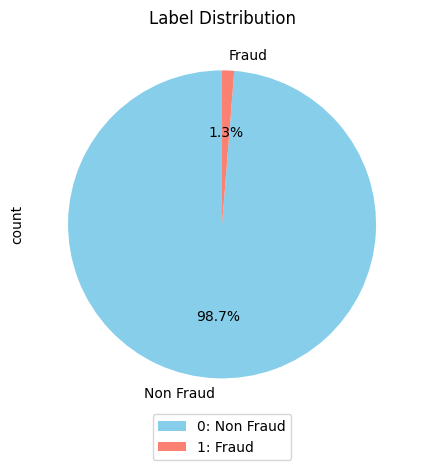

In [ ]:
colors = ['skyblue', 'salmon']
labels = ['Non Fraud', 'Fraud']

plt.figure(figsize=(5, 5))
complete_df["label"].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    labels=labels,
)

plt.title('Label Distribution')
plt.legend(
    ["0: Non Fraud", "1: Fraud"],
    loc="lower center", 
    bbox_to_anchor=(0.5, -0.13)
)
plt.gca().set_aspect('equal')
plt.show()

Berdasarkan pie chart di atas, dapat dilihat bahwa `label` memiliki ketidakseimbangan atau **imbalance** yang signifikan, dengan kelas `0: Non-Fraud` sebanyak 98.7% dan kelas `1: Fraud` sebanyak 1.3%. Hal ini dapat mempengaruhi kinerja model yang akan dibangun nantinya. Oleh karena itu, perlu dilakukan penanganan terhadap kasus ini.

Selanjutnya, kita akan melakukan analisis terhadap fitur-fitur secara keseluruhan dengan memvisualisasikan Kernel Density Estimation (KDE) dari fitur-fitur tersebut dengan hue label.

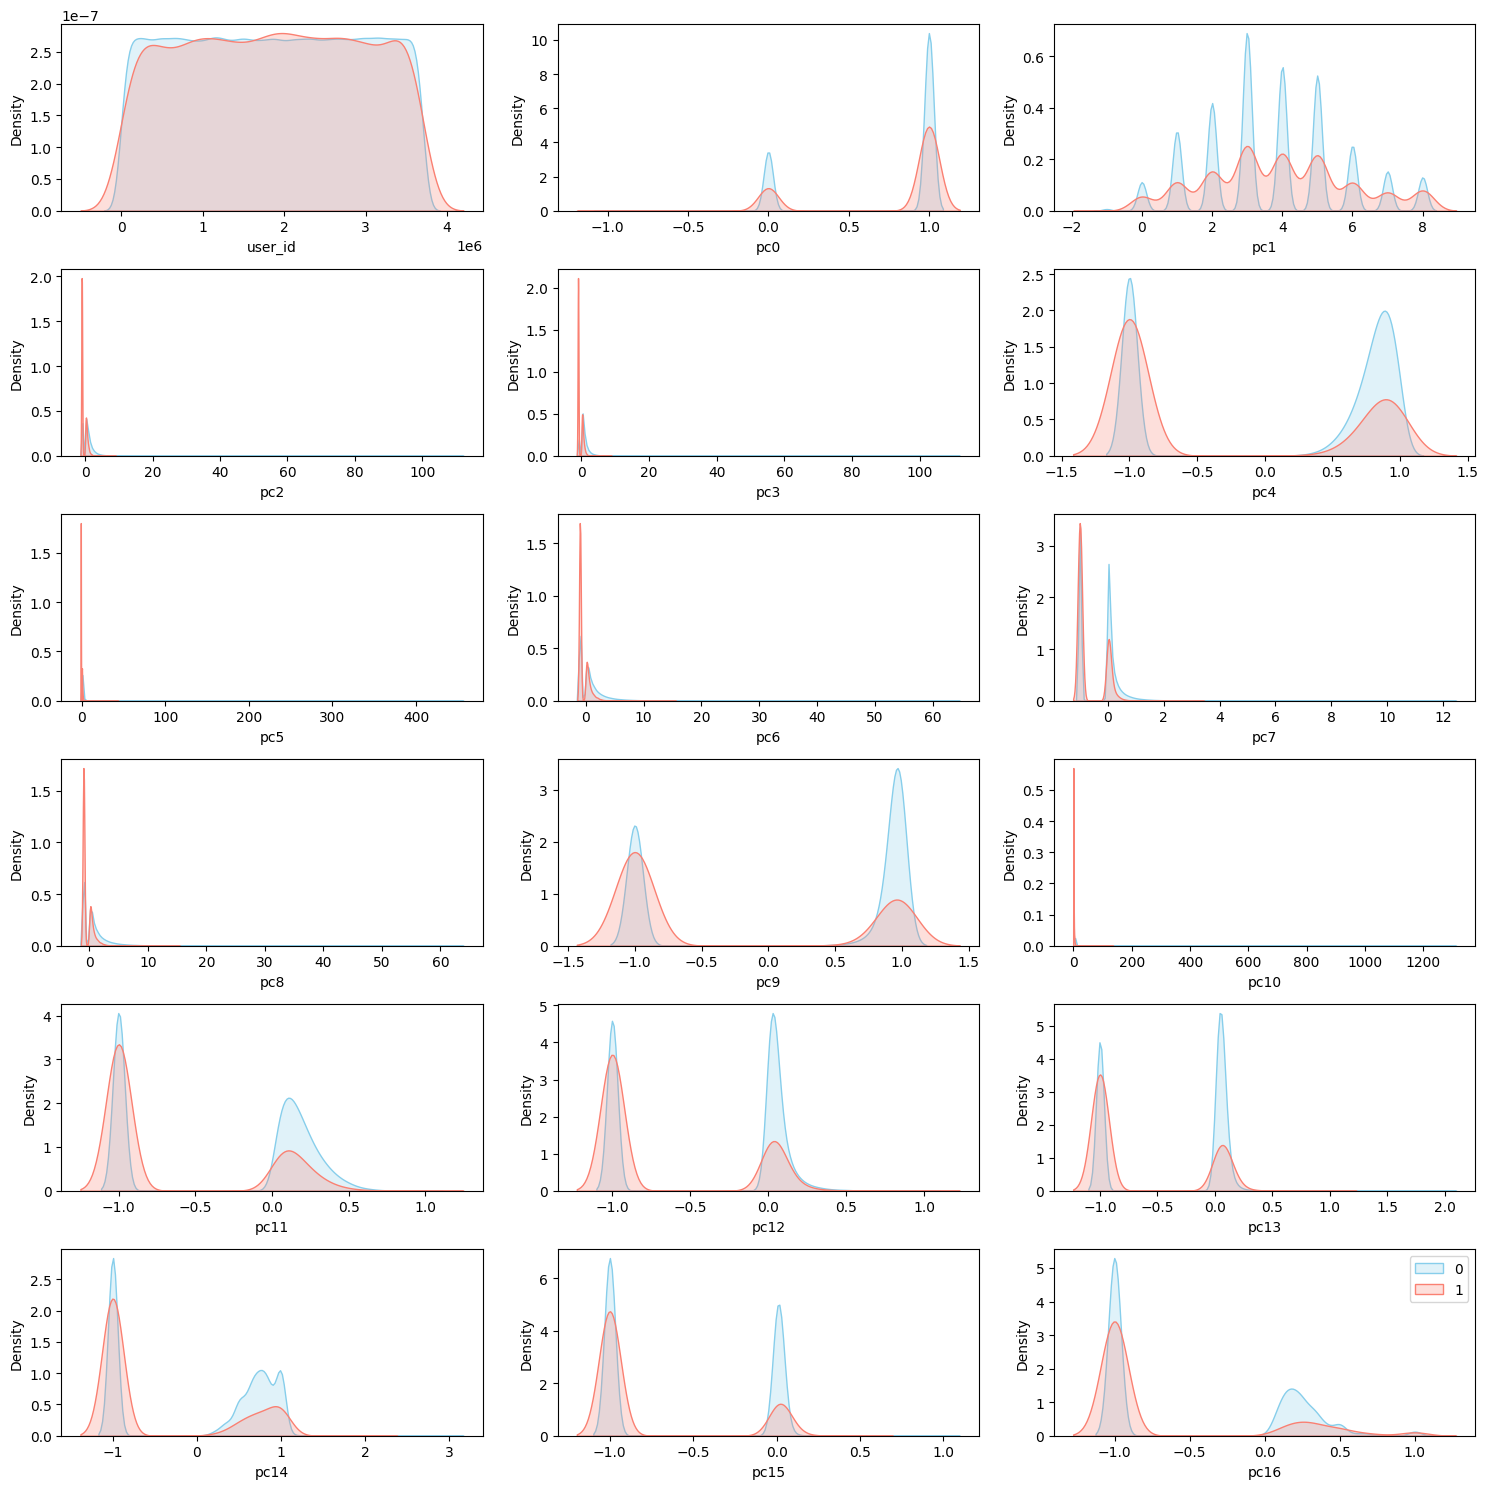

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(15, 15))
for i, col in enumerate(train.columns):
    if col == 'label':
        continue
    sns.kdeplot(train.loc[train['label'] == 0, col], label='0', fill=True, ax=axs[i//3, i%3], color=colors[0])
    sns.kdeplot(train.loc[train['label'] == 1, col], label='1',  fill=True, ax=axs[i//3, i%3], color=colors[1])
plt.tight_layout()
plt.legend()
plt.show()

Berdasarkan plot KDE di atas, dapat diambil beberapa poin berikut:
- **Perbedaan distribusi data antara kelas `0: Non-Fraud` dan kelas `1: Fraud`**. Pada kolom `pc4`, `pc7`, `pc9`, `pc12`, `pc13` terdapat perbedaan distribusi yang saling berkebalikan antarkelasnya. Hal ini menunjukkan potensi pentingnya fitur-fitur tersebut dalam membedakan nilai label.
- **Tingginya jumlah missing value untuk kelas `1: Fraud`**. Dapat dilihat pada kolom `pc4`, `pc9`, dan `pc11` - `pc16 terdapat missing value yang cukup tinggi untuk kelas tersebut. Ini dapat menjadi potensi pola untuk menentukan prediksi pada label.
- **Terdapat nilai outlier yang cukup ekstrem**. Di beberapa kolom, terdapat nilai yang sangat ekstrem yang dapat mempengaruhi kinerja model.

Setelah melihat persebaran data dari informasi user, selanjutnya kita akan melihat informasi mengenai aktivitas peminjaman yang berasal dari file `loan_activity.csv`.

In [ ]:
merged_df = pd.merge(loan_act, complete_df, on='user_id', how='left')
merged_df['loan_type'] = merged_df['loan_id'].astype('int')

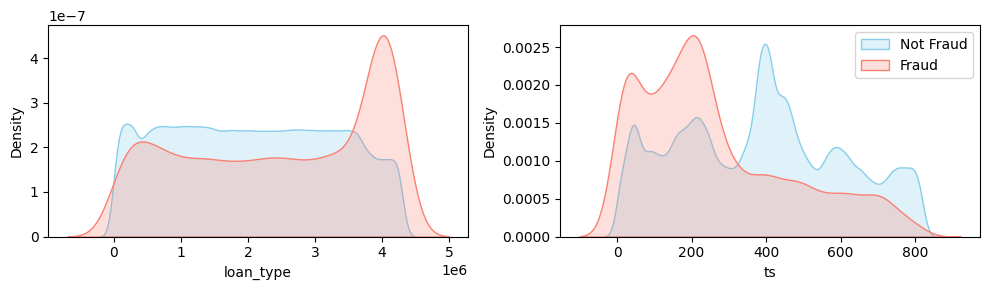

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

for i, col in enumerate(['loan_type', 'ts']):
    if col == 'user_id' or col == 'reference_contact':
        continue
    sns.kdeplot(merged_df.loc[merged_df['label'] == 0, col], label='0', fill=True, ax=axs[i], color=colors[0])
    sns.kdeplot(merged_df.loc[merged_df['label'] == 1, col], label='1',  fill=True, ax=axs[i], color=colors[1])
plt.tight_layout()
plt.legend(
    ['Not Fraud', 'Fraud'],
    loc='upper right'
)
plt.show()

Berdasarkan KDE plot di atas, dapat diambil beberapa insight berikut:
- **Loan Type**. Plot densitas untuk kolom ini menunjukkan perbedaan yang cukup jelas pada kedua kelas di label. Kasus `1: Fraud` memiliki puncak yang pada nilai loan_type yang tinggi sedangkan kasus `0: Non Fraud` memiliki distribusi yang lebih merata di seluruh nilai loan_type, bahkan menurun di nilai loan_type yang tinggi. Ini dapat memberikan informasi bahwa **fraud lebih sering terjadi pada jenis peminjaman yang lebih tinggi**.
- **Timestamp (ts)**.  Mirip dengan loan_type, densitas plot untuk kolom ini juga menunjukkan perbedaan yang cukup jelas antara kedua kelas. Kasus `1: Fraud` memiliki puncak yang lebih tinggi pada nilai ts yang rendah, sedangkan kasus `0: Non Fraud` memiliki distribusi yang lebih merata di seluruh nilai ts. Ini juga dapat memberikan informasi bahwa **fraud lebih sering terjadi pada suatu pola waktu tertentu (ts yang lebih rendah)**.

Lalu, untuk mendapatkan hubungan antara fitur-fitur dan label dengan lebih spesifik pada nilai fiturnya, kita akan melakukan analisis terhadap fitur-fitur dengan menggunakan ***pararrel coordinates plot***.

In [ ]:
'''
WARNING: Kode ini akan memakan waktu yang cukup lama untuk dijalankan, berpotensi membuat lag atau kernel crash.
Output dari kode ini adalah parallel coordinate plot yang dijelaskan dalam bentuk gambar di bawah ini.
'''

# columns = train.columns
# fig = px.parallel_coordinates(
#     train,color="label",
#     dimensions=columns,
#     color_continuous_scale=px.colors.diverging.Portland,
# )
# fig.show(renderer="notebook")

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/pcp.png" width="1000" height="390">
</div>

In [ ]:
'''
WARNING: Kode ini akan memakan waktu yang cukup lama untuk dijalankan, berpotensi membuat lag atau kernel crash
'''

# fig = px.parallel_coordinates(
#     train,color="label",
#     dimensions=['pc2', 'pc3', 'pc5', 'pc6', 'pc8'],
#     color_continuous_scale=px.colors.diverging.Portland,
# )
# fig.update_layout(
#     font=dict(size=18)  # Atur ukuran font sesuai kebutuhan
# )
# fig.show(renderer="notebook")

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/pcp23568.png" width="800" height="520">
</div>

Berdasarkan plot di atas, beberapa insight yang dapat diambil adalah:
- **Pola jalur yang lebih *tight* untuk kelas `1: Fraud`**. Dapat dilihat bahwa jalur yang dihasilkan oleh kelas `1: Fraud` lebih ketat di beberapa kolom seperti `pc5`. Dengan begitu, **metode statistikal seperti standar deviasi, mean, atau median** untuk setiap fitur dapat menjadi penting dalam membedakan nilai label.
- **Beberapa fitur memiliki kemiripan segi distribusinya**, contohnya fitur `pc2` dan `pc3` serta `pc6` dan `pc8`. Hal ini dapat menimbulkan redundansi pada model yang akan dibangun nantinya.

## 2.4 Analisis Missing Value 

Missing Value, Null Value, atau NaN values adalah data yang dapat dianggap tidak ada. Pada dataset yang diberikan, missing value direpresentasikan dengan nilai -1. Jika nilai -1 diganti dengan missing values, terdapat beberapa hal yang dapat ditemukan.

In [ ]:
# import missingno as msno
# msno.bar(complete_df, sort="descending")

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/Null_Bar.png" width="1000" height="500">
</div>

Seperti yang terlihat pada plot di atas, hanya terdapat dua kolom yang tidak memiliki NaN values. Selain itu, terdapat 15 dari 19 kolom di mana jumlah baris null melebihi jumlah baris bernilai.  

In [ ]:
# fraud_rows = complete_df[complete_df['label'] == 1]
# rows_with_nans = fraud_rows[fraud_rows.isnull().sum(axis=1) >= 14]
# count = len(rows_with_nans)

# print(count)
# print(len(fraud_rows))
# import matplotlib.pyplot as plt
# non_nan_count = len(fraud_rows) - count
# sizes = [count, non_nan_count]
# labels = ['Fraud Rows = 14 NaN', 'Fraud Rows < 14 NaN']
# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['gray', 'red'], startangle=90)
# plt.title('NaN Distribution of Fraud Rows')
# plt.legend(bbox_to_anchor=(0.75,0), loc=7)
# plt.show()

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/Nan_Fraud.png" width="682" height="525">
</div>

In [ ]:
# fraud_rows = complete_df[complete_df['label'] == 0]
# rows_with_nans = fraud_rows[fraud_rows.isnull().sum(axis=1) >= 14]
# count = len(rows_with_nans)
# print(count)
# print(len(fraud_rows))
# non_nan_count = len(fraud_rows) - count
# sizes = [count, non_nan_count]
# labels = ['Non-Fraud Rows = 14 NaN', 'Non-Fraud Rows < 14 NaN']
# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['gray', 'lightblue'], startangle=90)
# plt.title('NaN Distribution of Non-Fraud Rows')
# plt.legend(bbox_to_anchor=(0.75,0), loc=7)
# plt.show()

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/Nan_Not_Fraud.png" width="751" height="525">
</div>

Dari plot di atas, user yang ditandai fraud lebih cenderung memiliki banyak nilai yang NaN. Karena hal tersebut, missing value dapat dianggap sebagai data berguna yang tidak memerlukan imputasi. 

## 2.5 Loan Types

Jika `loan_types` di plot menggunakan histogram, dapat dilihat bahwa terdapat tiga puncak. Puncak-puncaknya terdapat pada tipe 1, 5, dan 10. Terdapat kemungkinan `loan_type` tipe 1 berjumlah banyak karena tipe 1 adalah batasan bawah, sehingga banyak transaksi loan menumpuk di tipe tersebut. Selain itu, `loan_type` tipe 7 sampai dengan 11 relatif jarang jika dibandingkan dengan tipe lain.

In [ ]:
# sns.histplot(loan_act['loan_type'])
# plt.show()

## 2.6 Kesimpulan EDA

Berikut adalah elaborasi dari poin-poin yang kamu sebutkan menjadi kalimat yang lebih baik:

1. **Pentingnya *Network* atau Hubungan dalam Deteksi Fraud**:
   *Network* memainkan peran yang penting dalam mendeteksi fraud. Sebagai contoh nyata, implementasi *network* dalam deteksi fraud telah berhasil diterapkan di sektor perbankan, di mana analisis hubungan antar akun dapat mengidentifikasi pola mencurigakan yang sulit terdeteksi dengan metode tradisional  . Dari sisi teknis, riset dalam deteksi fraud menggunakan metode data tabular dan arsitektur Graph Neural Networks (GNN) menunjukkan efektivitas yang signifikan dalam mengidentifikasi anomali berdasarkan hubungan antar data.

2. **Hubungan Kuat antara Train-Test-Non Borrower**:
   Terdapat hubungan yang kuat antara dataset `train`, `test`, dan `non_borrower`. Pengguna dalam dataset `train` dan `test` memiliki referensi kontak yang dapat terhubung dengan pengguna dalam dataset `non_borrower`. Ini memungkinkan kita membangun graph yang lebih komprehensif dan memperkaya informasi yang digunakan dalam model, meskipun data `non_borrower` tidak digunakan secara langsung dalam pelatihan, validasi, atau pengujian.

3. **Kesulitan dalam Intuisi Fitur yang Disamarkan**:
   Meskipun terdapat pola pada beberapa fitur seperti yang ditunjukkan oleh histogram atau KDE plot, penamaan fitur yang disamarkan membuat intuisi terhadap setiap fitur menjadi sulit. Tanpa mengetahui konteks spesifik dari setiap fitur, analisis yang lebih dalam menjadi terbatas dan sulit untuk diinterpretasikan secara langsung.

4. **Imbalance pada Label**:
   Ketidakseimbangan pada label dalam dataset dapat mengacaukan pemahaman model. Model cenderung lebih bias terhadap kelas mayoritas, yang mengakibatkan deteksi fraud pada kelas minoritas menjadi kurang akurat. Oleh karena itu, penanganan ketidakseimbangan ini menjadi krusial dalam meningkatkan performa model.

5. **Signifikansi Missing/Null Values**:
   Dengan jumlah yang signifikan, missing values dapat menjadi salah satu fitur penting dalam analisis data. missing values seringkali mencerminkan informasi yang hilang yang bisa menjadi indikator signifikan dalam mendeteksi pola anomali atau fraud. 

6. **Potensi Metode Statistikal sebagai Fitur**:
   Berdasarkan parallel coordinate plot di EDA, simpangan beberapa fitur yang lebih ketat memberikan indikasi untuk mempertimbangkan metode statistikal seperti standar deviasi (std), mean, modus, dan lain-lain dalam analisis data. Fitur tersebut diharapkan mampu mendapatkan pola secara general bagi kelas di dalam label.

In [5]:
del train, test, non_borrower, loan_act, complete_df, merged_df

# 3. Data Preprocessing
Kembali ke [Daftar Isi](#Daftar-Isi)

## 3.1 Integrasi Data User

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/integrasi.png" width="600" height="600">
</div>

Seperti yang sudah di-mention pada EDA bahwa ada tiga data yang memuat suatu informasi yang sama yaitu train, test, dan non_borrower_user. Diperoleh informasi tambahan bahwa:

- Keduanya memiliki **identifier yang sama** (user_id).
- Keduanya memiliki **fitur yang sama** (pc0-pc16) – meski terdapat perbedaan pada data train dengan adanya kolom label.
- **Tidak adanya duplikasi identifier**, yang berarti ketiga data berisi informasi yang saling lepas.
- Ketiga data **saling me-*refer***, sehingga untuk mendapatkan representasi graph dan network yang lengkap harus diketahui keseluruhan user_id di ketiga data.

Berdasarkan beberapa poin tersebut, kami memutuskan untuk **mengintegrasikan data** pada file `train`, `test`, dan `non borrower user` menjadi suatu dataframe baru yang dinamakan `complete_df`. Untuk nilai label pada baris yang berasal dari data test dan non_borrow akan diimputasi dengan nilai NaN, karena di data test nantinya ini akan menjadi target yang diprediksi. 

In [ ]:
start_time = time.time()
train = pd.read_csv(f'{config["readpath"]}train.csv')
test = pd.read_csv(f'{config["readpath"]}test.csv')
non_borrower = pd.read_csv(f'{config["readpath"]}non_borrower_user.csv')
loan_act = pd.read_csv(f'{config["readpath"]}loan_activities.csv')

len_train=len(train)
len_test=len(test)

# gabungkan train, test, dan non_borrower_user untuk feature engineering
complete_df = pd.concat([train,test,non_borrower], axis=0) 

# membuat loan_id sebagai index dan loan_type sebagai kategori
loan_act["loan_id"] = loan_act.index
loan_act["loan_type"] = loan_act["loan_type"].astype('category') 
user_id = pd.DataFrame()
user_id["user_id"] = complete_df["user_id"].values
del train, test, non_borrower

In [ ]:
def optimize_and_transform(config,results, feature_matrix, method, layer_name, progress_name,handle_NaNs=None):
    """
    Mengoptimalkan model berdasarkan metode yang ditentukan (XGB, RFE, RFECV) 
    dan mengubah feature_matrix sesuai dengan itu.
    """
    boolean_columns = []
    # terdapat pilihan untuk menghilangkan NaN values sebelum memasukkan ke model
    if handle_NaNs is not None:
        for column in feature_matrix.columns:
            if feature_matrix[column].dtype == 'float64' or feature_matrix[column].dtype == 'int64':
                feature_matrix[column].fillna(-1, inplace=True)
            elif feature_matrix[column].dtype == 'category':
                if '-1' not in feature_matrix[column].cat.categories:
                    feature_matrix[column] = feature_matrix[column].cat.add_categories('-1')
                feature_matrix[column].fillna('-1', inplace=True)
            elif feature_matrix[column].dtype == 'boolean':
                feature_matrix[column] = feature_matrix[column].astype('Int64').fillna(-1)

    # mengubah boolean menjadi tipe data semulanya
    for column in boolean_columns:
        feature_matrix[column] = feature_matrix[column].replace(-1, np.nan).astype('boolean')
    X = feature_matrix.iloc[:len_train].drop(columns=["label","user_id"],errors='ignore')
    y = feature_matrix.iloc[:len_train]['label']
    X_test = feature_matrix.iloc[len_train:(len_train+len_test)].drop(columns=["label","user_id"],errors='ignore')
    print(X.shape, y.shape, X_test.shape)

    random_search = RandomizedSearchCV(
        config[layer_name]['xgb'],
        param_distributions=config[layer_name]['params'],
        **config[layer_name]['random_search_params']
    )
    random_search.fit(X, y)
    
    # simpan hasilnya
    results[layer_name][progress_name]['best_params'] = random_search.best_params_
    results[layer_name][progress_name]['best_score'] = random_search.best_score_
    results[layer_name][progress_name]['best_estimator'] = random_search.best_estimator_
    
    print(f"Best parameters: {results[layer_name][progress_name]['best_params']}")
    print(f"Best score: {results[layer_name][progress_name]['best_score']}")
    
    # feature importance
    feature_names = X.columns
    importances = results[layer_name][progress_name]['best_estimator'].feature_importances_
    feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances*100})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    display(feature_importances_df.head(10))
    results[layer_name][progress_name]['feature_importances'] = dict(zip(feature_importances_df['Feature'], feature_importances_df['Importance']))
    # menerapkan kalkulasi RFE/RFECV berdasarkan parameter
    selected_features=feature_names
    if method == 'RFE':
        selector = RFE(results[layer_name][progress_name]['best_estimator'], **config[layer_name]['recursive_feature_elimination'])
        selector = selector.fit(X, y)
        
        feature_matrix.drop(columns=['label'], inplace=True,errors='ignore')
        colname = X.columns
        selected_features = colname[selector.support_]
        feature_matrix = selector.transform(feature_matrix.drop(columns=["label","user_id"],errors='ignore'))
        feature_matrix = pd.DataFrame(feature_matrix, columns=selected_features)
        #X_test = feature_matrix.iloc[len_train:(len_train+len_test)].drop(columns=["label","user_id"],errors='ignore')
        print(f"Selected features: {selected_features}")
    elif method == 'RFECV':
        selector=RFECV(results[layer_name][progress_name]['best_estimator'],
                       **config[layer_name]['recursive_feature_elimination_cv']
               )
        selector = selector.fit(X, y)
        feature_matrix.drop(columns=['label'], inplace=True,errors='ignore')
        colname = X.columns
        selected_features = colname[selector.support_]
        feature_matrix = selector.transform(feature_matrix.drop(columns=["label","user_id"],errors='ignore'))
        feature_matrix = pd.DataFrame(feature_matrix, columns=selected_features)
        #X_test = feature_matrix.iloc[len_train:(len_train+len_test)].drop(columns=["label","user_id"],errors='ignore')
        print(f"Selected features: {selected_features}")
    # pembuatan file submisi
    if method == 'XGB':
        y_pred_proba = results[layer_name][progress_name]['best_estimator'].predict_proba(X_test)[:, 1]
    else:
        #X_test=feature_matrix.iloc[len_train:(len_train+len_test)].drop(columns=["label","user_id"],errors='ignore')
        y_pred_proba = selector.predict_proba(X_test)[:, 1]
    
    submission = pd.DataFrame({'user_id': user_id["user_id"].iloc[len(X):(len(X)+len(X_test))].values, 'label': y_pred_proba})
    submission.to_csv(f'{config["writepath"]}submission_{layer_name}_{progress_name}_{method.lower()}.csv', index=False)
        # mengembalikan NaN
    if handle_NaNs is not None:
        for column in feature_matrix.columns:
            if feature_matrix[column].dtype == 'float64' or feature_matrix[column].dtype == 'int64':
                feature_matrix[column].replace(-1, np.nan, inplace=True)
            elif feature_matrix[column].dtype == 'category':
                feature_matrix[column].replace('-1', np.nan, inplace=True)
            elif feature_matrix[column].dtype == 'Int64':  # Assuming boolean columns were converted to int
                feature_matrix[column] = feature_matrix[column].replace(-1, np.nan).astype('boolean')
    if method == 'XGB':
        return feature_matrix, selected_features
    else:
        return feature_matrix, selected_features, selector

In [ ]:
complete_df, selected_features = optimize_and_transform(config,results, complete_df, 'XGB', 'raw', 'step1')
results['raw']['step1']['end_features']=selected_features

(857899, 17) (857899,) (367702, 17)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'subsample': 1.0, 'scale_pos_weight': 20, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 1.0, 'base_score': 0.7}
Best score: 0.028408598025241528


,Feature,Importance
2,pc2,49.276497
6,pc6,9.660824
11,pc11,6.307931
15,pc15,5.611158
0,pc0,5.589085
1,pc1,3.646534
16,pc16,3.251179
4,pc4,2.827325
10,pc10,2.677221
7,pc7,2.065268


In [ ]:
end_time = time.time()
execution_time = end_time - start_time
results['raw']['step1']['runtime'] = execution_time

## 3.2 Missing Value Handling

Berdasarkan EDA, diperoleh informasi bahwa distribusi *missing value* cukup banyak dan berpotensi menjadi fundamental bagi perancangan suatu fitur  dengan importansi tinggi. Selain itu, EDA juga menunjukkan bahwa fitur statistikal seperti std, mean, dan modus untuk tiap fitur juga berpotensi menjadi fitur yang cukup penting. Oleh karena itu, kami memutuskan untuk tetap mempertahankan missing value.

Kami **mengganti nilai** `-1` (yang diberikan di awal untuk menandai missing value) dengan nilai `NaN`. Hal ini dapat mempermudah ekstraksi fitur untuk missing value (menghitung null_count, menghitung fitur statistikal, dll) serta tidak akan menimbulkan bias pada pengambilan fitur statistikal karena nilai NaN secara otomatis tidak akan dihitung.

In [10]:
# mengganti nilai -1 menjadi NaN
complete_df.replace(-1, np.nan, inplace=True)

# 4. Feature Engineering
Kembali ke [Daftar Isi](#Daftar-Isi)

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/flowchart_fixx.png" width="1200" height="600">
</div>

Sebagai permulaan, kami akan menjelaskan bagaimana proses keseluruhan pengerjaan projek ini. Pertama-tama, dilakukan **Exploratory Data Analysis (EDA)**, di mana analisis umum, kontak referensi, nilai label dan fitur, tipe pinjaman, dan nilai null dieksplorasi untuk memahami dataset. Setelah itu, data diproses melalui **Data Preprocessing** yang mencakup integrasi tabel dari berbagai sumber data (train, test, non-borrower user) dan penanganan nilai yang hilang, menghasilkan complete_df sebagai output.

Pada tahap **Feature Engineering and Selection**, data dibagi menjadi beberapa layer untuk menghasilkan fitur yang lebih komprehensif. **Layer 1** menghasilkan 23 fitur, yang kemudian digabungkan dengan data aktivitas pinjaman untuk menghasilkan output layer 1. **Layer 2** menghasilkan 93 fitur mentah yang kemudian dipilih menggunakan metode Random SearchCV dengan XGBoost dan Recursive Feature Elimination (RFE), menghasilkan 30 fitur terpilih. **Layer 3** mencakup 273 fitur yang disaring menjadi 150 fitur melalui RFE, dan akhirnya menghasilkan 130 fitur terpilih menggunakan kombinasi Random SearchCV dan RFE. Pada tahap **Final Modelling**, model XGBoost dilatih menggunakan Optuna untuk mencari hyperparameter terbaik, kemudian model terbaik digunakan untuk prediksi dan pengajuan hasil.

## 4.1 Main Ideas

Dalam proses feature engineering, kami melihat dengan paradigma data tabular dan paradigma data graph atau network dengan memanfaatkan seluruh dataset yang diberikan. Dalam paradigma data tabular, kami akan menggunakan metode Deep Feature Synthesis (DFS) dari library Featuretools sedangkan dalam paradigma data graph kami menggunakan metode Breadth First Search (BFS). 

Untuk mempermudah pemahaman dan pengerjaan, kami akan membagi paradigma tersebut menjadi tiga buah layer, dengan layer 1 dan 2 menggunakan paradigma data tabular sedangkan layer 3 menggunakan paradigma data graph. Berikut penjelasan dari setiap layer:

1. **Layer 1**: 
    Membuat fitur DFS baru hanya dengan menggunakan fitur di `complete_df`.

2. **Layer 2**: Menggunakan informasi gabungan dari `complete_df` dan `loan_act` untuk membuat fitur DFS, terdiri dari dua sublayer berikut:
    - **Layer 2.1**: Membuat fitur baru dari dataframe hasil merge `complete_df` dengan `loan_act` di `user_id`. Fitur didapatkan dengan mengagregasi nilai berdasarkan `user_id`. 
    - **Layer 2.2**: Membuat fitur baru dari dataframe layer 2.1 dengan tambahan meng-extend dan mengagregasi nilai fitur kolom `reference_contact` untuk setiap `user_id`.
    - **Layer 2.3**: Membuat profiles fitur yang ideal berdasarkan loan_types. kalo jadi mungkin bisa ditambahkan penjelasan.

3. **Layer 3**: Mengimplementasikan BFS untuk setiap node – satu `user_id` dianggap sebagai sebuah node dengan fitur sebagai nilai node tersebut – terhadap adjacent (`reference contact`) dan mengagregasinya untuk mendapatkan fitur baru. Fitur yang di agregasi merupakan fitur naive dan fitur baru yang dihasilkan oleh Layer 2  yang telah di filter menggunakan RFE. Untuk mendapatkan informasi yang lebih terperinci, layer ini dibagi menjadi dua sublayer berikut:
    - **Layer 3.1**: Mengagregasi nilai fitur pada setiap node adjacent yang berada di distance 1 untuk dijadikan nilai fitur baru.
        - Fitur naive:  dengan menggagregasi fitur naive pada distance 1 kita mendapat informasi mengenai user lain yang terhubung langusng dengan LU atau dengan kata lain kita mendapat informasi mengenai RC dari LU.
        - Fitur hasil Layer 2: dengan mengagregasi fitur hasil Layer 2 pada distance 1 kita mendapat informasi mengenai user yang terhubung dengan RC. sehingga hasil aggregasi ini menghasilkan fitur baru yang memuat informasi mengnenai orang orang yang terhubung dengan  RC.

    - **Layer 3.2**: Mengagregasi nilai fitur pada setiap node adjacent yang berada di distance 2 untuk dijadikan nilai fitur baru.
        - Fitur naive:  dengan menggagregasi fitur naive pada distance 2 kita mendapat informasi mengenai user lain yang terhubung dengan LU dalam distance 2. 
        - Fitur hasil Layer 2: dengan mengagregasi fitur hasil Layer 2 pada distance 1 kita mendapat informasi mengenai user yang terhubung dengan user pada distance 2. Sehingga hasil aggregasi ini menghasilkan fitur baru yang memuat informasi mengnenai orang orang yang terhubung dengan user pada distance 2, atau dengan kata lain RC dari user pada distance 2 dari LU.

Jadi Layer 3 ini kita membuat fitur fitur baru yang berisi informasi mengenai tetangga dari setiap user pada distance 1 dan 2, serta informasi mengenai tetangga dari tetangga setiap user pada distance 1 dan 2.Setelah itu kita juga melakukan agregasi pada 2 distance yang telah di hitung dengan mencari rata rata setiap fitur dan diberi bobot dimana fitur distance 1 diberi bobot lebih tinggi dibanding distance 2


## 4.2 Implementasi

### 4.2.1 Layer 1

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/layer 1.png" width="380" height="380">
</div>

Pertama-tama, kami membuat fungsi yang memungkinkan untuk menentukan range di setiap fitur. Range ini digunakan untuk memfilter data sebelum dilakukan pemrosesan lebih lanjut. Apabila data berada pada range tersebut, maka akan diberikan nilai True, selain itu akan diberikan nilai False.

In [11]:
start_time = time.time()
def add_columns_within_fraud_range_bool(df, fraud_ranges):
    """
    Fungsi add_columns_within_fraud_range_bool akan menambahkan kolom baru is_within_fraud_ranges yang berisi boolean
    apakah data tersebut berada dalam range yang dianggap fraud atau tidak, ini akan membantu model untuk menentukan
    apakah data tersebut fraud atau tidak berdasarkan range yang dianggap fraud
    """
    def is_within_fraud_ranges(row):
        if pd.isna(row['pc0']) or row['pc0'] == -1:
            return False
        
        for column, range_values in fraud_ranges.items():
            if pd.isna(row[column]) or row[column] == -1:
                continue 

            bottom, top = range_values
            if (bottom is not None and row[column] < bottom) or (top is not None and row[column] > top):
                return False
            
        return True 
    
    df['is_within_fraud_ranges'] = df.apply(is_within_fraud_ranges, axis=1).astype('boolean')

    return df

In [12]:
fraud_ranges = config['first_layer']['fraud_ranges']

Lalu, pada implementasi layer 1 ini, kami secara manual merancang **fitur baru dengan memanfaatkan fitur yang sudah ada di** `complete_df`. Fitur baru yang dihasilkan adalah sebagai berikut:
1. `null_count`: Jumlah nilai null pada setiap baris atau tuple data di `complete_df`.
2. `referenced_count`: Jumlah user yang mereferensikan user tersebut di `loan_activity`.
3. `time_diff`: Selisih waktu peminjaman pertama dan terakhir yang dilakukan oleh user di `loan_activity`.
4. `avg_time_between`: Rata-rata selisih waktu peminjaman yang dilakukan oleh user di `loan_activity`.
5. `std_time_between`: Standar deviasi dari selisih waktu peminjaman yang dilakukan oleh user di `loan_activity`.

In [13]:
complete_df['null_count'] = complete_df.drop(columns=['label']).isna().sum(axis=1)
complete_df['referenced_count'] = complete_df['user_id'].map(loan_act['reference_contact'].value_counts()).fillna(0).astype('Int64')

complete_df = add_columns_within_fraud_range_bool(complete_df, fraud_ranges)


loan_act_sorted = loan_act.sort_values(by=['user_id', 'ts']).copy()
loan_act_sorted['time_diff'] = loan_act_sorted.groupby('user_id')['ts'].diff()

avg_time_diff = loan_act_sorted.groupby('user_id')['time_diff'].mean().reset_index(name='avg_time_between')
std_time_diff = loan_act_sorted.groupby('user_id')['time_diff'].std().reset_index(name='std_time_between')
avg_time_diff['avg_time_between'].fillna(-1, inplace=True)
std_time_diff['std_time_between'].fillna(-1, inplace=True)
avg_time_diff = avg_time_diff[['user_id', 'avg_time_between']]
std_time_diff = std_time_diff[['user_id', 'std_time_between']]
complete_df = pd.merge(complete_df, avg_time_diff, on='user_id', how='left')
complete_df = pd.merge(complete_df, std_time_diff, on='user_id', how='left')

complete_df['avg_time_between'].fillna(-2, inplace=True)
complete_df['std_time_between'].fillna(-2, inplace=True)
complete_df.drop(columns=['user_id_x'], inplace=True, errors='ignore')

del loan_act_sorted, avg_time_diff, std_time_diff


In [ ]:
complete_df["pc1_cat"] = complete_df["pc1"].astype('category')
complete_df["pc0"] = complete_df["pc0"].astype(bool)
complete_df["null_count_cat"] = complete_df["null_count"].astype('category')
complete_df,selected_features = optimize_and_transform(config,results, complete_df, 'XGB', 'first_layer', 'step1',True)
results['first_layer']['step1']['end_features']=selected_features

(857899, 24) (857899,) (367702, 24)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'subsample': 1.0, 'scale_pos_weight': 20, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 1.0, 'base_score': 0.7}
Best score: 0.03987537345442291


,Feature,Importance
20,avg_time_between,27.897635
2,pc2,18.095978
11,pc11,7.076542
6,pc6,6.439407
15,pc15,4.697346
19,is_within_fraud_ranges,4.441618
21,std_time_between,4.438765
0,pc0,3.032667
23,null_count_cat,2.905223
22,pc1_cat,2.900039


In [ ]:
end_time = time.time()
execution_time = end_time - start_time
results['first_layer']['step1']['runtime'] = execution_time

### 4.2.2 Layer 2

Untuk implementasi pada layer 2 ini, dengan mengacu pada poin hasil EDA, bahwa metode statistikal seperti standar deviasi, mean, atau median untuk setiap fitur dapat menjadi penting dalam membedakan nilai label, kami akan membuat fitur baru dengan mengagregasi nilai berdasarkan `user_id`.

Kami akan menggunakan metode [Deep Feature Synthesis](https://featuretools.alteryx.com/en/stable/getting_started/afe.html) (DFS) dari library [Featuretools](https://featuretools.alteryx.com/en/stable/index.html) untuk membuat fitur baru. Deep Feature Synthesis adalah metode otomatisasi untuk melakukan feature engineering yang dapat dilakukan pada data yang saling ber-relasi (relational data) maupun temporal data.

Pada metode ini, ada dua konsep utama feature engineering yang digunakan, yaitu:
1. **Aggregation**: Menghitung statistik agregasi dari dua atau lebih nilai yang **saling berhubungan**, dengan contoh aggregtion function seperti `mean`, `sum`, `max`, `min`, `std`, dan lain-lain. Fungsi tersebut akan ditentukan pada variabel `agg_primitives`.

2. **Transformation**: Mentransformasikan satu atau lebih data **dalam satu dataframe** menjadi bentuk yang lebih informatif, seperti menghitung selisih waktu, menghitung frekuensi, dan lain-lain. Jenis transformation function yang digunakan akan ditentukan pada variabel `trans_primitives`.

Untuk penjelasan selengkapnya, dapat dilihat pada bagian perbedaan antara aggregation dan transformation di [sini](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html#Aggregation-vs-Transform-Primitive).

<div align="center">
    <h3>Aggregation</h3>
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/agg.png" width="1000" height="173">
    <h3>Transformation</h3>
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/trans.png" width="1000" height="155">
    <br>
    <a href="https://featuretools.alteryx.com/en/stable/getting_started/primitives.html#Aggregation-vs-Transform-Primitive">Sumber Gambar</a>
</div>

Pada layer 2 dan 3, kami juga menggunakan 2 istilah baru, yaitu:
1. **Loan User (LU)**: User yang **sedang melakukan peminjaman** di `loan_activity`.
2. **Referenced Contact (RC)**: User yang **direferensikan** oleh *Loan User (LU)* di tabel `loan_activity`.


#### 4.2.2.1 Layer 2.1

In [16]:
start_time = time.time()
loan_act = pd.merge(loan_act, complete_df, left_on='reference_contact', right_on='user_id', how='left')
loan_act  = loan_act .drop(columns=['reference_contact', 'user_id_y'])
loan_act["loan_type_int"] = loan_act["loan_type"].astype('Int64')

In [17]:
agg_primitives_RC = config['second_layer']['agg_primitives_RC']
trans_primitives_RC = config['second_layer']['trans_primitives_RC']
primitive_options_RC = config['second_layer']['primitive_options_RC']

In [19]:
RC_loan_act = loan_act.copy()
es_RC_loan_profile = ft.EntitySet(id="loan_profile")

es_RC_loan_profile = es_RC_loan_profile.add_dataframe(
    dataframe_name="loan_act_RC",
    dataframe=RC_loan_act,
    index="loan_id_x"
)

es_RC_loan_profile = es_RC_loan_profile.normalize_dataframe(
    base_dataframe_name="loan_act_RC",
    new_dataframe_name="loan_profile",
    index="loan_type",
)

loan_profile_df, _ = ft.dfs(
    entityset=es_RC_loan_profile,
    target_dataframe_name="loan_profile",
    agg_primitives=agg_primitives_RC,
    trans_primitives=trans_primitives_RC,
    max_depth=1,
    verbose=True,
    primitive_options=primitive_options_RC,
)

del RC_loan_act, es_RC_loan_profile

Built 20 features
Elapsed: 00:01 | Progress: 100%|██████████


In [20]:
loan_act.reset_index(inplace=True, drop=True)
loan_profile_df.reset_index(level=0, inplace=True, drop=False)
merged_df = pd.merge(loan_act, loan_profile_df, on='loan_type', how='left')
columns_to_process = ['pc' + str(i) for i in range(1, 17)] + ['ts', 'avg_time_between', 'std_time_between', 'null_count']

# Carilah selisih rata-rata
for col in columns_to_process:
    mean_col = f'MEAN(loan_act_RC.{col})'
    merged_df[f'{col}_MEAN_DIFF'] = (merged_df[col] - merged_df[mean_col]).abs()

del loan_profile_df, columns_to_process

Pada tahap ini, dua macam fitur tambahan akan dibuat. Fitur pertama adalah `TOTAL_WEIGHTED_SUM` dan fitur kedua adalah `TOTAL_WMEAN_DIFF`. Pada dasarnya, informasi `user_id` dan `reference_contact` ditambahkan ke `loan_activities`. Lalu data tersebut digunakan untuk menghitung rata-rata setiap kelompok `loan_type`. Rata-rata tersebut akan dibandingkan dengan setiap pelaku transaksi. Harapannya adalah jika perbedaanya besar, maka model dapat mengetahui bahwa terdapat perbedaan.

In [21]:


def calculate_metrics(df, weights):
    """
    Fungsi ini menghitung hasil penjumlahan total dan juga rata-rata terbobot dari kolom-kolom yang berakhir dengan '_MEAN_DIFF' dalam sebuah dataframe.
    Jika ditemukan nilai NaN, maka bobot akan berubah untuk mengimbangi perhitungan rata-rata.
    """
    # Filter kolom yang diakhiri dengan '_MEAN_DIFF'
    mean_diff_cols = [col for col in df.columns if col.endswith('_MEAN_DIFF')]
    df['TOTAL_WEIGHTED_SUM'] = 0.0
    df['TOTAL_WMEAN_DIFF'] = 0.0
    
    for index, row in tqdm(df.iterrows(), desc="Calculating metrics"):
        weighted_sum = 0.0
        adjusted_weighted_sum = 0.0
        total_weight = 0.0
        
        for col in mean_diff_cols:
            if pd.notna(row[col]):
                weight = weights.get(col, 1)  # Bobot default adalah 1 jika tidak ditentukan
                weighted_sum += row[col] * weight
                adjusted_weighted_sum += row[col] * weight
                total_weight += weight
                
        df.at[index, 'TOTAL_WEIGHTED_SUM'] = weighted_sum
        
        if total_weight > 0:
            df.at[index, 'TOTAL_WMEAN_DIFF'] = adjusted_weighted_sum / total_weight
        else:
            df.at[index, 'TOTAL_WMEAN_DIFF'] = pd.NA
    
    return df

weights = config['first_layer']['weights']
merged_df = calculate_metrics(merged_df, weights)

columns_to_drop = [col for col in merged_df.columns if col.endswith('_MEAN_DIFF')]
merged_df = merged_df.drop(columns=columns_to_drop)
columns_to_drop = [col for col in merged_df.columns if col.startswith('MEAN(')]
merged_df = merged_df.drop(columns=columns_to_drop)

merged_df.rename(columns={
    'TOTAL_WEIGHTED_SUM': 'TOTAL_WEIGHTED_SUM_RC',
    'TOTAL_WMEAN_DIFF': 'TOTAL_WMEAN_DIFF_RC'
}, inplace=True)

del columns_to_drop

Calculating metrics: 4300999it [09:20, 7673.07it/s]


In [22]:
loan_act=pd.read_csv(f'{config["readpath"]}loan_activities.csv')
loan_act["loan_id"] = loan_act.index
loan_act["loan_type"] = loan_act["loan_type"].astype('category') 

In [23]:
loan_act_LU_data = pd.merge(loan_act, complete_df, left_on='user_id', right_on='user_id', how='left')
loan_act_LU_data["loan_type_int"] = loan_act_LU_data["loan_type"].astype('int64')

In [24]:
agg_primitives_LU = config['second_layer']['agg_primitives_LU']
trans_primitives_LU = config['second_layer']['trans_primitives_LU']
primitive_options_LU = config['second_layer']['primitive_options_LU']

In [25]:
loan_act_LU_fraud = loan_act_LU_data[loan_act_LU_data["label"] == 1].copy()
loan_act_LU_fraud["loan_id"] = loan_act_LU_fraud.index
es_loan_profile_LU_fraud = ft.EntitySet(id="loan_profile")

es_loan_profile_LU_fraud = es_loan_profile_LU_fraud.add_dataframe(
    dataframe_name="loan_act_LU",
    dataframe=loan_act_LU_fraud,
    index="loan_id"
)

es_loan_profile_LU_fraud = es_loan_profile_LU_fraud.normalize_dataframe(
    base_dataframe_name="loan_act_LU",
    new_dataframe_name="loan_profile",
    index="loan_type",
)

loan_profile_df, _ = ft.dfs(
    entityset=es_loan_profile_LU_fraud,
    target_dataframe_name="loan_profile",
    agg_primitives=agg_primitives_LU,
    trans_primitives=trans_primitives_LU,
    max_depth=1,
    verbose=True,
    primitive_options=primitive_options_LU,
)
del loan_act_LU_fraud, es_loan_profile_LU_fraud

Built 20 features
Elapsed: 00:00 | Progress: 100%|██████████


In [26]:
loan_act.reset_index(inplace=True, drop=True)
loan_profile_df.reset_index(level=0, inplace=True, drop=False)
merged_df = pd.merge(merged_df, loan_profile_df, on='loan_type', how='left')
columns_to_process = ['pc' + str(i) for i in range(1, 17)] + ['ts', 'avg_time_between', 'std_time_between', 'null_count']

for col in columns_to_process:
    mean_col = f'MEAN(loan_act_LU.{col})'
    merged_df[f'{col}_MEAN_DIFF'] = (merged_df[col] - merged_df[mean_col]).abs()

del loan_profile_df, columns_to_process

In [27]:
merged_df = calculate_metrics(merged_df, weights)
columns_to_drop = [col for col in merged_df.columns if col.endswith('_MEAN_DIFF')]
merged_df = merged_df.drop(columns=columns_to_drop)
columns_to_drop = [col for col in merged_df.columns if col.startswith('MEAN(')]
merged_df = merged_df.drop(columns=columns_to_drop)
merged_df.rename(columns={
    'TOTAL_WEIGHTED_SUM': 'TOTAL_WEIGHTED_SUM_LU',
    'TOTAL_WMEAN_DIFF': 'TOTAL_WMEAN_DIFF_LU'
}, inplace=True)

del columns_to_drop

Calculating metrics: 4300999it [09:31, 7531.98it/s]


#### 4.2.2.2 Layer 2.2 dan 2.3

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/layer 2.2 fix.png" width="800" height="380">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/layer 2.3 fix.png" width="800" height="700">
</div>

Jadi, pada layer 2.2 dan 2.3, kami akan membuat fitur baru dengan mengagregasi nilai berdasarkan `user_id` dan `reference_contact`. Berikut penjelasan lebih lanjut untuk masing-masing layer:
- Layer 2.2: Membuat fitur baru dari dataframe hasil merge complete_df dengan loan_act di user_id. Fitur didapatkan dengan mengagregasi nilai berdasarkan user_id. 
- Layer 2.3: Membuat fitur baru dari dataframe layer 2.2 dengan tambahan meng-extend dan mengagregasi nilai fitur kolom reference_contact untuk setiap user_id.


Pertama-tama, kami akan menginisialisaasi variabel `agg_primitives` dan `trans_primitives` yang akan digunakan pada metode DFS. Kemudian, kami akan membuat fitur baru dengan menggunakan metode DFS pada layer 2.2 dan 2.3.

In [28]:
agg_primitives= config['second_layer']['agg_primitives']
trans_primitives=config['second_layer']['trans_primitives']
primitive_options=config['second_layer']['primitive_options']

In [29]:
es = ft.EntitySet(id="fraud")
es =es.add_dataframe(
    dataframe_name="complete_df",
    dataframe=complete_df,
    index="user_id"
)

es = es.add_dataframe(
    dataframe_name="loan_act",
    dataframe=merged_df,
    index="loan_id_x"
)

es = es.add_relationship(
    parent_dataframe_name="complete_df",
    parent_column_name="user_id",
    child_dataframe_name="loan_act",
    child_column_name="user_id_x"
)

In [30]:
feature_matrix, _= ft.dfs(
    entityset= es,
    target_dataframe_name="complete_df",
    agg_primitives= agg_primitives,
    trans_primitives= trans_primitives,
    max_depth=1,
    verbose=True,
    primitive_options= primitive_options,
    features_only= False,
)
del merged_df, es

Built 93 features
Elapsed: 00:00 | Progress:   0%|          

Elapsed: 14:35 | Progress: 100%|██████████


In [32]:
feature_matrix["pc0"]=feature_matrix["pc0"].astype("Int64")
feature_matrix['MODE(loan_act.loan_type)']=feature_matrix["MODE(loan_act.loan_type)"].astype("Int64")
feature_matrix['MODE(loan_act.pc1_cat)']=feature_matrix['MODE(loan_act.pc1_cat)'].astype("Int64")
feature_matrix.drop(columns=['pc1_cat', 'null_count_cat'],inplace=True)
non_categorical_columns = feature_matrix.select_dtypes(exclude=['category']).columns
for col in non_categorical_columns:
    feature_matrix[col].fillna(-1,inplace=True)
#feature_matrix.drop(columns=[f"pc{i}" for i in range(17)], inplace=True, errors='ignore')

In [33]:
feature_matrix.to_csv(f'{config["writepath"]}{config["instance"]}layer12.csv', index=False)
feature_matrix = pd.read_csv(f'{config["writepath"]}{config["instance"]}layer12.csv')

In [34]:
# feature_matrix.drop(columns=['null_count', 'referenced_count', 'is_within_fraud_ranges',
#                              'avg_time_between', 'std_time_between'], inplace=True, errors='ignore')
categorical_cols = complete_df.select_dtypes(include=['object', 'category']).columns
complete_df.drop(columns=categorical_cols, inplace=True)
for column in complete_df.columns:
    if complete_df[column].dtype == 'boolean':
        complete_df[column] = complete_df[column].astype('Int64')
# complete_df.fillna(-1,inplace=True)
# feature_matrix.drop(columns=['user_id'],inplace=True,errors='ignore')
feature_matrix.fillna(-1,inplace=True)

In [35]:
labels=feature_matrix['label']
user_id=pd.DataFrame()
user_id['user_id']=complete_df["user_id"].values

In [37]:
feature_matrix,selected_features, selector = optimize_and_transform(config,results, feature_matrix, 'RFE', 'second_layer', 'step1')
results['second_layer']['step1']['end_features']=selected_features
end_time = time.time()
execution_time = end_time - start_time
results['second_layer']['step1']['runtime'] = execution_time
feature_matrix['label']=labels
feature_matrix['user_id']=user_id['user_id']

(857899, 90) (857899,) (367702, 90)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.6, 'scale_pos_weight': 10, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.8, 'base_score': 0.8}
Best score: 0.05085822989146184


,Feature,Importance
27,MAX(loan_act.ts),10.233159
2,pc2,3.984788
28,MAX_MIN_DELTA(loan_act.ts),3.830072
53,MEAN(loan_act.ts),2.960673
89,STD(loan_act.ts),2.304892
17,null_count,1.815111
19,is_within_fraud_ranges,1.802174
34,MEAN(loan_act.loan_type_int),1.534520
0,pc0,1.532669
43,MEAN(loan_act.pc16),1.513675


Selected features: Index(['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
       'pc16', 'null_count', 'referenced_count', 'is_within_fraud_ranges',
       'avg_time_between', 'std_time_between', 'MAX(loan_act.ts)',
       'MAX_MIN_DELTA(loan_act.ts)', 'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)',
       'MEAN(loan_act.avg_time_between)', 'MEAN(loan_act.loan_type_int)',
       'MEAN(loan_act.pc11)', 'MEAN(loan_act.pc15)', 'MEAN(loan_act.pc16)',
       'MEAN(loan_act.pc7)', 'MEAN(loan_act.ts)',
       'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)', 'MIN(loan_act.ts)',
       'MODE(loan_act.loan_type)', 'STD(loan_act.loan_type_int)',
       'STD(loan_act.ts)'],
      dtype='object')


### 4.2.3 Layer 3

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/l3 lengkappp.png" width="800" height="800">
</div>

**Layer 3**: Layer 3.1 dan 3.2 di implementasikan secara bersamaan dengan dalam kelas fungsi yang sama, yaitu Layer_3.Fungsi ini melakukan BFS untuk distance 1 dan 2 dengan menggunakan `min`,`max`, `mean` dan `std` sebagai aggregation function nya. Selain itu juga menghitung jumlah tetangga setiap user dan `Mean` serta `weighted mean` dari 2 BFS pada distance 1 dan 2 untuk mengagregasi mean pada fitur tersebut pada distance 1 dan 2. Sebagai mana telah di sebutkan pada Kesimpulan EDA bahwa distance antara 2 user penting. Oleh karena itu kita menambahkan Weight, yaitu 0.7 dan 0.3 secara berurutan untuk distance 1 dan 2.
fungsi ini di panggil untuk setiap user,dengan menggunakan fungsi dari library yaitu `DataFrame.progress_apply` agar dapat melihat prosesnya


In [39]:
start_time = time.time()

In [40]:
feature_matrix,selected_features = optimize_and_transform(config,results, feature_matrix, 'XGB', 'second_layer', 'step2')
results['second_layer']['step2']['end_features']=selected_features

(857899, 30) (857899,) (367702, 30)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 25, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.6, 'base_score': 0.8}
Best score: 0.050953283141402905


,Feature,Importance
15,MAX(loan_act.ts),17.313499
24,MEAN(loan_act.ts),7.475080
16,MAX_MIN_DELTA(loan_act.ts),7.086728
2,pc2,6.955035
29,STD(loan_act.ts),4.691865
12,is_within_fraud_ranges,3.814213
19,MEAN(loan_act.loan_type_int),3.728016
3,pc3,3.581997
22,MEAN(loan_act.pc16),3.243662
0,pc0,3.133816


In [41]:
#concat
#complete_df.reset_index(inplace=True)
#feature_matrix=pd.concat([feature_matrix, complete_df.drop(columns=['label'])], axis=1)
feature_matrix.to_csv(f'{config["writepath"]}{config["instance"]}checkpoint_layer12_rfe_withnaive.csv', index=False)
end_time = time.time()
execution_time = end_time - start_time
results['second_layer']['step2']['runtime'] = execution_time

In [43]:
start_time = time.time()
user_to_ref = loan_act.groupby('user_id')['reference_contact'].apply(list).to_dict()
user_to_ref = {k: v for k, v in tqdm(user_to_ref.items(), desc="Processing user_to_ref")}

ref_to_user = loan_act.groupby('reference_contact')['user_id'].apply(list).to_dict()
ref_to_user = {k: v for k, v in tqdm(ref_to_user.items(), desc="Processing ref_to_user")}

Processing ref_to_user: 100%|██████████| 2698874/2698874 [00:00<00:00, 5907163.81it/s]


In [50]:
tqdm.pandas()

class Layer_3(BaseEstimator, TransformerMixin):
    def __init__(self, user_to_ref,ref_to_user, comp,col,average_weights):
        self.comp = comp
        self.col=col
        self.user_to_ref = user_to_ref
        self.ref_to_user = ref_to_user
        self.comp_dict = {}
        self.average_weights = average_weights
        for i in tqdm(self.col, desc="Processing comp_dict"):
            if i == 'user_id':
                continue
            self.comp_dict[i] = self.comp.set_index('user_id')[i].to_dict()

    def fit(self, X, y=None):
        return self

    def bfs_optimized(self, user_id, column, layer):
        visited = set([user_id])
        queue = deque([(user_id, 0)])
        mean=0
        std=0
        max=0
        mean=0
        n=0
        num=0
        while queue:
            current_user, depth = queue.popleft()
            if depth > layer:
                break
            elif depth == layer:
                val = self.comp_dict[column].get(current_user, -1)
                n+=1
                if val != -1 or val != np.nan:
                    num+=1
                    mean+=val
                    max=max if max>val else val

            else:
                # Traverse user_to_ref
                for next_user in self.user_to_ref.get(current_user, []):
                    if next_user not in visited:
                        visited.add(next_user)
                        queue.append((next_user, depth + 1))
                # Traverse ref_to_user
                for next_user in self.ref_to_user.get(current_user, []):
                    if next_user not in visited:
                        visited.add(next_user)
                        queue.append((next_user, depth + 1))                       
        del visited,queue

        visited = set([user_id])
        queue = deque([(user_id, 0)])

        while queue:
            current_user, depth = queue.popleft()
            if depth > layer:
                break
            elif depth == layer:
                val = self.comp_dict[column].get(current_user, -1)
                if val != -1 or val != np.nan:
                    std+=((val-mean)*(val-mean))

            else:
                # Traverse user_to_ref
                for next_user in self.user_to_ref.get(current_user, []):
                    if next_user not in visited:
                        visited.add(next_user)
                        queue.append((next_user, depth + 1))
                # Traverse ref_to_user
                for next_user in self.ref_to_user.get(current_user, []):
                    if next_user not in visited:
                        visited.add(next_user)
                        queue.append((next_user, depth + 1))
        if num>0:
            std=std/num
            std=math.sqrt(std)
            mean=mean/num
        return n,mean,max,std
    def transform(self, X):
        for i in self.col:
            if i == 'user_id':
                continue
            print(i)
            layers = range(1, 3)

            for j in layers:
                n,mean, max,std = zip(*X['user_id'].progress_apply(lambda x: self.bfs_optimized(x, i, j)))
                X[f'layer{j}_num'] = n
                X[f'{i}_layer{j}_std'] = std
                X[f'{i}_layer{j}_mean'] = mean
                X[f'{i}_layer{j}_max'] = max
            
            # Aggregate
            agg_columns = [f'{i}_layer{j}_mean' for j in layers]
            agg_data = X[agg_columns].values  # Extract the data once for efficiency

            # Vectorized operations for aggregation
            X[f'{i}_agg_mean'] = np.nanmean(agg_data, axis=1)
            
            # Add weight and aggregate weighted mean
            average_weights =self.average_weights
            weighted_values = np.nansum(agg_data * average_weights, axis=1) / np.sum(average_weights)
            X[f'{i}_agg_mean_weighted'] = weighted_values

        return X

In [47]:
feature_matrix.drop(columns=['index','label'],inplace=True,errors='ignore')

In [48]:
col=feature_matrix.columns

In [51]:
Layer_3x_transformer = Layer_3(user_to_ref, ref_to_user, feature_matrix, col, config['third_layer']['average_weights'])
feature_matrix = Layer_3x_transformer.fit_transform(feature_matrix)

Processing comp_dict: 100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


pc0


100%|██████████| 3700550/3700550 [00:51<00:00, 72556.61it/s]


pc1


100%|██████████| 3700550/3700550 [00:51<00:00, 72124.73it/s]


pc2


100%|██████████| 3700550/3700550 [00:52<00:00, 70891.41it/s]


pc3


100%|██████████| 3700550/3700550 [00:52<00:00, 70908.44it/s]


pc6


100%|██████████| 3700550/3700550 [00:52<00:00, 71075.48it/s]


pc8


100%|██████████| 3700550/3700550 [00:50<00:00, 72883.72it/s]


pc11


100%|██████████| 3700550/3700550 [00:51<00:00, 72523.46it/s]


pc12


100%|██████████| 3700550/3700550 [00:51<00:00, 72209.73it/s]


pc15


100%|██████████| 3700550/3700550 [00:51<00:00, 71856.97it/s]


pc16


100%|██████████| 3700550/3700550 [00:50<00:00, 72934.40it/s]


null_count


100%|██████████| 3700550/3700550 [00:49<00:00, 74615.06it/s]


referenced_count


100%|██████████| 3700550/3700550 [00:50<00:00, 73783.52it/s]


is_within_fraud_ranges


100%|██████████| 3700550/3700550 [00:49<00:00, 74140.85it/s]


avg_time_between


100%|██████████| 3700550/3700550 [00:50<00:00, 72622.80it/s]


std_time_between


100%|██████████| 3700550/3700550 [00:51<00:00, 71993.25it/s]


MAX(loan_act.ts)


100%|██████████| 3700550/3700550 [00:50<00:00, 72613.32it/s]


MAX_MIN_DELTA(loan_act.ts)


100%|██████████| 3700550/3700550 [00:50<00:00, 73975.91it/s]


MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)


100%|██████████| 3700550/3700550 [00:50<00:00, 73237.73it/s]


MEAN(loan_act.avg_time_between)


100%|██████████| 3700550/3700550 [00:50<00:00, 72770.87it/s]


MEAN(loan_act.loan_type_int)


100%|██████████| 3700550/3700550 [00:51<00:00, 72407.40it/s]


MEAN(loan_act.pc11)


100%|██████████| 3700550/3700550 [00:51<00:00, 71555.77it/s]


MEAN(loan_act.pc15)


100%|██████████| 3700550/3700550 [00:52<00:00, 71043.90it/s]


MEAN(loan_act.pc16)


100%|██████████| 3700550/3700550 [00:51<00:00, 72056.39it/s]


MEAN(loan_act.pc7)


100%|██████████| 3700550/3700550 [00:51<00:00, 72195.31it/s]


MEAN(loan_act.ts)


100%|██████████| 3700550/3700550 [00:51<00:00, 71928.37it/s]


MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)


100%|██████████| 3700550/3700550 [00:51<00:00, 71834.28it/s]


MIN(loan_act.ts)


100%|██████████| 3700550/3700550 [00:51<00:00, 72395.24it/s]


MODE(loan_act.loan_type)


100%|██████████| 3700550/3700550 [00:50<00:00, 72859.51it/s]


STD(loan_act.loan_type_int)


100%|██████████| 3700550/3700550 [00:51<00:00, 71620.08it/s]


STD(loan_act.ts)


100%|██████████| 3700550/3700550 [00:51<00:00, 71311.10it/s]


In [53]:
feature_matrix.to_csv(f'{config["writepath"]}{config["instance"]}checkpoint_layer123_pre_rfe.csv', index=False)

In [9]:
feature_matrix = pd.read_csv(f'{config["writepath"]}{config["instance"]}checkpoint_layer123_pre_rfe.csv')

In [21]:
feature_matrix['label']=labels.values
feature_matrix['user_id']=user_id['user_id'].values
feature_matrix,selected_features, selector = optimize_and_transform(config,results, feature_matrix, 'RFE', 'third_layer', 'step1')
results['third_layer']['step1']['end_features']=selected_features
feature_matrix.to_csv(f'{config["writepath"]}{config["instance"]}checkpoint_layer123_rfe_150.csv', index=False)
feature_matrix['label']=labels.values
feature_matrix['user_id']=user_id['user_id'].values
end_time = time.time()
execution_time = end_time - start_time
results['third_layer']['step1']['runtime'] = execution_time

#### 4.2.3.1 Layer 3.1

In [39]:
start_time = time.time()
feature_matrix['label']=labels.values
feature_matrix['user_id']=user_id['user_id'].values
feature_matrix_cv,selected_features, selector = optimize_and_transform(config,results, feature_matrix, 'RFECV', 'third_layer', 'step2')

(857899, 150) (857899,) (367702, 150)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'subsample': 0.6, 'scale_pos_weight': 10, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.8, 'base_score': 0.8}
Best score: 0.061639166008239946


,Feature,Importance
15,MAX(loan_act.ts),9.094588
16,MAX_MIN_DELTA(loan_act.ts),2.508967
2,pc2,2.496325
24,MEAN(loan_act.ts),2.102350
10,null_count,1.971016
29,STD(loan_act.ts),1.811508
74,pc16_layer1_max,1.222779
0,pc0,1.101826
6,pc11,1.091233
19,MEAN(loan_act.loan_type_int),1.059481


Fitting estimator with 150 features.
Fitting estimator with 140 features.
Selected features: Index(['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
       'pc16',
       ...
       'MIN(loan_act.ts)_agg_mean', 'MIN(loan_act.ts)_agg_mean_weighted',
       'MODE(loan_act.loan_type)_layer2_std',
       'MODE(loan_act.loan_type)_layer2_mean',
       'STD(loan_act.loan_type_int)_layer2_std', 'STD(loan_act.ts)_layer1_std',
       'STD(loan_act.ts)_layer1_mean', 'STD(loan_act.ts)_layer1_max',
       'STD(loan_act.ts)_agg_mean', 'STD(loan_act.ts)_agg_mean_weighted'],
      dtype='object', length=130)


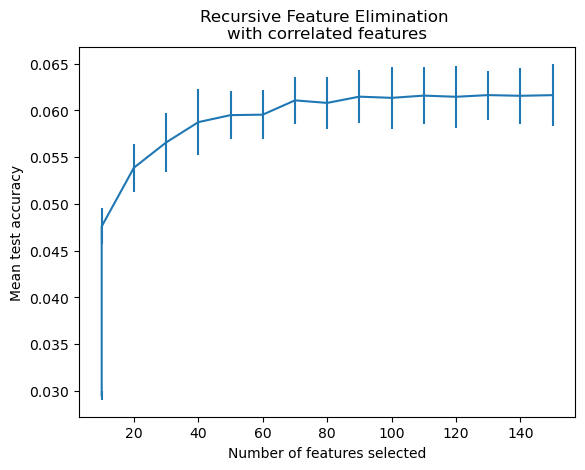

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(selector.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=[max(10,10*i) for i in range(cv_results.shape[0])],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [55]:
feature_matrix_cv['label']=labels.values
feature_matrix_cv['user_id']=user_id['user_id'].values
feature_matrix_cv,selected_features, selector = optimize_and_transform(config,results, feature_matrix_cv, 'RFE', 'third_layer', 'step2')
end_time = time.time()
execution_time = end_time - start_time
results['third_layer']['step2']['runtime'] = execution_time

(857899, 130) (857899,) (367702, 130)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.6, 'scale_pos_weight': 10, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.8, 'base_score': 0.8}
Best score: 0.06165830152204334


,Feature,Importance
15,MAX(loan_act.ts),9.151251
16,MAX_MIN_DELTA(loan_act.ts),2.837958
2,pc2,2.739667
29,STD(loan_act.ts),2.382808
24,MEAN(loan_act.ts),2.207728
10,null_count,1.981611
65,pc16_layer1_max,1.416658
19,MEAN(loan_act.loan_type_int),1.240152
0,pc0,1.227707
12,is_within_fraud_ranges,1.170827


Selected features: Index(['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
       'pc16', 'null_count', 'referenced_count', 'is_within_fraud_ranges',
       'avg_time_between', 'std_time_between', 'MAX(loan_act.ts)',
       'MAX_MIN_DELTA(loan_act.ts)', 'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)',
       'MEAN(loan_act.avg_time_between)', 'MEAN(loan_act.loan_type_int)',
       'MEAN(loan_act.pc11)', 'MEAN(loan_act.pc15)', 'MEAN(loan_act.pc7)',
       'MEAN(loan_act.ts)', 'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)',
       'MIN(loan_act.ts)', 'MODE(loan_act.loan_type)',
       'STD(loan_act.loan_type_int)', 'STD(loan_act.ts)', 'pc1_layer1_mean',
       'pc1_layer1_max', 'pc1_agg_mean_weighted', 'pc2_layer1_std',
       'pc2_layer1_max', 'pc2_agg_mean_weighted', 'pc3_layer1_max',
       'pc11_layer1_max', 'pc12_layer1_max', 'pc12_layer2_max',
       'pc15_layer1_std', 'pc15_layer1_mean', 'pc15_layer1_max',
       'pc15_layer2_max', 'pc16_layer1_std', 'pc16_layer1_mean',
       'pc1

#### 4.2.3.2 Layer 3.2

In [66]:
start_time = time.time()
feature_matrix_cv['label']=labels.values
feature_matrix_cv['user_id']=user_id['user_id'].values
feature_matrix_cv,selected_features = optimize_and_transform(config,results, feature_matrix_cv, 'XGB', 'third_layer', 'step3')

(857899, 70) (857899,) (367702, 70)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.6, 'scale_pos_weight': 10, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.8, 'base_score': 0.8}
Best score: 0.06198045320779916


,Feature,Importance
15,MAX(loan_act.ts),13.094282
16,MAX_MIN_DELTA(loan_act.ts),4.592699
2,pc2,3.928245
28,STD(loan_act.ts),2.592755
23,MEAN(loan_act.ts),2.403677
10,null_count,2.085136
45,pc16_layer1_max,2.084483
12,is_within_fraud_ranges,2.013921
0,pc0,1.896736
19,MEAN(loan_act.loan_type_int),1.808133


In [50]:
results['third_layer']['step3']['end_features']=selected_features
feature_matrix_cv.to_csv(f'{config["writepath"]}{config["instance"]}checkpoint_layer123_rfecv_rfe70.csv', index=False)
feature_matrix_cv['label']=labels.values
feature_matrix_cv['user_id']=user_id['user_id'].values
end_time = time.time()
execution_time = end_time - start_time
results['third_layer']['step3']['runtime'] = execution_time

In [71]:

X = feature_matrix_cv.iloc[:len_train].drop(columns=["label","user_id"],errors='ignore')
y = feature_matrix_cv.iloc[:len_train]['label']
X_test = feature_matrix_cv.iloc[len_train:(len_train+len_test)].drop(columns=["label","user_id"],errors='ignore')
print(X.shape, y.shape, X_test.shape)
def objective(trial):
    param = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_categorical('gamma', [0.5, 1, 1.5, 2, 5]),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6,1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 25),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 4.5),
        'base_score': trial.suggest_float('base_score', 0.5, 0.9)
    }
    estimator= XGBClassifier(**param, device="cuda", enable_categorical = True,random_state=config['random_state'])
    return cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='average_precision').mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20)

[I 2024-07-14 19:26:18,247] A new study created in memory with name: no-name-f16077fa-f2a2-4245-a976-89e27b0740bc


(857899, 70) (857899,) (367702, 70)


[I 2024-07-14 19:28:36,903] Trial 0 finished with value: 0.06052430220813669 and parameters: {'min_child_weight': 9, 'gamma': 0.5, 'subsample': 0.7898706196851131, 'colsample_bytree': 0.712425945363854, 'max_depth': 3, 'learning_rate': 0.07744404478766155, 'n_estimators': 1216, 'scale_pos_weight': 14.760936939266543, 'reg_alpha': 0.76207206002736, 'reg_lambda': 1.8315419877251835, 'base_score': 0.5094004598252039}. Best is trial 0 with value: 0.06052430220813669.
[I 2024-07-14 19:30:23,342] Trial 1 finished with value: 0.05912746687901564 and parameters: {'min_child_weight': 4, 'gamma': 2, 'subsample': 0.9808415659144833, 'colsample_bytree': 0.9352211912609871, 'max_depth': 3, 'learning_rate': 0.020669328519437636, 'n_estimators': 917, 'scale_pos_weight': 15.33485635387984, 'reg_alpha': 0.8017887837749598, 'reg_lambda': 2.811659466544518, 'base_score': 0.7915715104138145}. Best is trial 0 with value: 0.06052430220813669.
[I 2024-07-14 19:35:05,227] Trial 2 finished with value: 0.061290

In [72]:
param=study.best_params
best_estimator=XGBClassifier(**param, device="cuda", enable_categorical = True,random_state=config['random_state'])
best_estimator.fit(X,y)

XGBClassifier(base_score=0.5987421571604699, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7743279633295593, device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.023965255793588783, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1234, n_jobs=None,
              num_parallel_tree=None, random_state=1001, ...)

In [73]:
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

In [74]:
submission = pd.DataFrame({'user_id': user_id["user_id"].iloc[len_train:(len_train+len_test)].values, 'label': y_pred_proba})
submission.to_csv(f'{config["writepath"]}{config["instance"]}submission_layer123_optuna.csv', index=False)


In [79]:
best_estimator

XGBClassifier(base_score=0.5987421571604699, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7743279633295593, device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.023965255793588783, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1234, n_jobs=None,
              num_parallel_tree=None, random_state=1001, ...)

In [90]:
file_name = "Stack Overfit_XGBClassifier.pkl"
pickle.dump(best_estimator, open(file_name, "wb"))
xgb_model_loaded = pickle.load(open(file_name, "rb"))
test = X_test
np.all(xgb_model_loaded.predict_proba(test)[:, 1]==best_estimator.predict_proba(test)[:, 1])

True

In [97]:
feature_names = X_test.columns
feature_names = X.columns
importances = best_estimator.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances*100})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
pd.set_option('display.max_rows', 25)
display(feature_importances_df.head(25))

,Feature,Importance
15,MAX(loan_act.ts),16.670931
16,MAX_MIN_DELTA(loan_act.ts),4.894200
2,pc2,4.794261
28,STD(loan_act.ts),3.294157
23,MEAN(loan_act.ts),2.925149
45,pc16_layer1_max,2.335859
10,null_count,2.298510
12,is_within_fraud_ranges,2.172333
0,pc0,1.960472
19,MEAN(loan_act.loan_type_int),1.896228


In [123]:
installed_packages = {pkg.key for pkg in pkg_resources.working_set}

# Menyimpan nama library beserta versi yang digunakan ke file requirements.txt
with open('requirements.txt', 'w') as f:
    for package in sorted(installed_packages):
        version = pkg_resources.get_distribution(package).version
        f.write(f"{package}=={version}\n")

# 5. Model Development
Kembali ke [Daftar Isi](#Daftar-Isi)

## 5.1 Extreme Gradient Boosting (XGBoost)

Metode Extreme Gradient Boosting ([XGBoost](https://xgboost.readthedocs.io/en/stable/)) menggunakan konsep boosting pada tree secara bertahap, seperti yang ditunjukkan oleh Gambar X. Berikut adalah penjelasan  tentang **langkah-langkah** yang dilakukan oleh XGBoost:

1. **Input Dataset (X, Y)**:
   Proses dimulai dengan menyediakan data input yang terdiri dari fitur-fitur (X) dan label atau target (Y) yang akan digunakan untuk melatih model. Data ini mencakup informasi yang diperlukan untuk melakukan prediksi dan mengetahui hasil yang diharapkan.

2. **Inisialisasi Model**:
   XGBoost memulai dengan membuat model dasar, biasanya berupa sebuah tree yang sederhana atau prediksi konstan. Model ini berfungsi sebagai titik awal, memberikan dasar awal yang akan ditingkatkan melalui proses boosting.

3. **Menghitung Residual**:
   Setelah model awal dibangun, XGBoost menghitung residu atau kesalahan prediksi. Residu ini adalah selisih antara nilai yang diprediksi oleh model saat ini dengan nilai aktual (Y). Residu ini menunjukkan seberapa jauh prediksi model dari target sebenarnya.

4. **Membangun Tree Baru dengan Regularisasi**:
   Berdasarkan residu yang dihitung, XGBoost membangun tree baru (F₁(X)). Tree ini dirancang untuk memprediksi residu dari model sebelumnya, berusaha untuk memperbaiki kesalahan yang masih ada. Setiap node dalam tree dipilih untuk meminimalkan kesalahan prediksi residu. Setiap tree yang ditambahkan dalam model dikonfigurasi dengan parameter regularisasi (αi). Parameter ini mengontrol seberapa besar kontribusi tree tersebut dalam model keseluruhan, mencegah model mengalami overfitting.

5. **Pembaruan Model (Fm(X))**:
   Model akumulatif diperbarui dengan menambahkan kontribusi dari tree baru yang telah dibangun. Formula Fm(X) = Fm-1(X) + αm hm(X, rm-1) menunjukkan bahwa model saat ini (Fm(X)) adalah kombinasi dari model sebelumnya (Fm-1(X)) dan kontribusi dari tree terbaru yang dikalikan dengan parameter regularisasi (αm). Ini menggambarkan bagaimana setiap tree baru memperbaiki model secara iteratif dengan mengatasi residu dari model sebelumnya.

6. **Evaluasi dengan Fungsi Loss (L(Y, F(X)))**:
   XGBoost menggunakan fungsi loss (L) untuk mengevaluasi seberapa baik model saat ini (F(X)) memprediksi nilai aktual (Y). Fungsi loss ini harus dapat didiferensiasi sehingga metode gradient descent dapat diterapkan untuk optimisasi. Evaluasi ini penting untuk memastikan bahwa model terus berkembang menuju prediksi yang lebih akurat.

7. **Iterasi Ulang**:
   Langkah-langkah di atas diulang untuk setiap tree hingga mencapai jumlah tree maksimum yang telah ditentukan atau sampai peningkatan pada model menjadi minimal (early stopping). Pada setiap iterasi, tree baru dibangun untuk mempelajari kesalahan prediksi yang masih ada, sehingga model secara keseluruhan menjadi lebih kuat dan akurat.

Dengan mengikuti langkah-langkah ini, XGBoost membangun model yang kompleks dan akurat melalui kombinasi banyak tree sederhana. Setiap tree baru memperbaiki kesalahan yang dilakukan oleh tree sebelumnya, menciptakan model yang kuat dan mampu menangani berbagai jenis data dan tugas prediksi dengan sangat baik.

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/xgb.png" width="800" height="550">
    <br>
    <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html">Sumber Gambar</a>
</div>

Kami menggunakan model XGBoost dengan didasarkan kepada beberapa **alasan** berikut:

1. **Real-World Appliccation**:
   Deteksi fraud di dunia nyata biasanya berupa rule-based yang juga dapat dianalogikan sebagai aturan if-else, sangat cocok untuk model tree. Model XGBoost yang berbasis pada algoritma tree, diharapkan juga dapat menangkap pola dalam data dan membangun rule-based application untuk mengenali data mencurigakan yang menunjukkan adanya fraud.

2. **Skema Boosting**:
   Sebagai salah satu keunggulan XGBoost, skema boosting dapat secara terus menerus membuat model baru yang difokuskan pada kesalahan yang dibuat oleh model sebelumnya. Proses ini membantu mengurangi bias dan meningkatkan akurasi prediksi. Dalam konteks deteksi fraud, pendekatan ini memastikan bahwa model terus belajar dari kesalahan sebelumnya, sehingga mampu mendeteksi berbagai jenis fraud dengan lebih efektif.

3. **Pemahaman terhadap Intuisi Model XGBoost**:
   Salah satu tantangan dalam mengimplementasikan prediksi model machine learning adalah keterbukaan model. XGBoost akan menjadi model yang dapat dijelaskan dengan baik karena berbasis pada decision tree, yang secara intuitif mudah dipahami.

4. **Hyperparameter Tuning yang Mudah**:
   Dengan banyaknya parameter yang bisa di-*tuning*, kita dapat mencari model XGBoost dengan spesifikasi terbaik untuk mengatasi tugas deteksi fraud ini. Metode untuk mendapatkan paramter terabik itu juga banyak tersedia, misalnya dengan Grid Search, Random Search, maupun yang lebih efektif seperti Optuna. Kemudahan dalam men-*tuning* parameter seperti ini menjadi keuntungan tersendiri dalam menggunakan model XGBoost.

5. **Analisis Feature Importance**:
   XGBoost memiliki kemampuan untuk memberikan informasi tentang pentingnya setiap fitur dalam membuat prediksi. Feature importance ini sangat berguna untuk analisis lebih lanjut, membantu mengidentifikasi fitur mana yang paling berpengaruh terhadap deteksi fraud. Informasi ini berguna baik untuk bidang teknis (mengoptimalkan model) maupun non-teknis (membuat keputusan bisnis).

Dengan alasan-alasan tersebut, XGBoost menjadi pilihan yang kuat dan andal untuk tugas-tugas seperti deteksi fraud, di mana kemampuan untuk menangkap pola kompleks, memperbaiki kesalahan secara iteratif, dan memberikan penjelasan yang jelas dari prediksi model sangat penting.

## 5.2 Recursive Feature Elimination 

<div align="center">
    <img src="https://raw.githubusercontent.com/mdfwg/first-rep/main/images/rfe.png" width="800" height="490">
    <br>
    <a href="https://www.blog.trainindata.com/recursive-feature-elimination-with-python/">Sumber Gambar</a>
</div>

Dengan banyaknya jumlah data di awal, terlebih telah dilakukan feature engineering yang menghasilkan lebih banyak lagi fitur, maka peran seleksi fitur menjadi krusial agar proses *development model* menjadi lebih efisien dan hasil yang didapat lebih optimal. Kami menggunakan metode [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) (RFE) dari *library* [Scikit-learn](https://scikit-learn.org/stable/index.html) untuk melakukan seleksi fitur. RFE adalah metode seleksi fitur yang bekerja dengan cara mengeliminasi fitur satu per satu berdasarkan *ranking* yang diberikan oleh model yang digunakan (XGBoost).

## 5.3 Recursive Feature Elimination - Cross Validation (RFECV)

RFECV (Recursive Feature Elimination with Cross-Validation) adalah metode seleksi fitur dalam machine learning yang menggabungkan teknik *recursive feature elimination* (RFE) dengan validasi silang (*cross-validation*)

Kami menggunakan RFECV (Recursive Feature Elimination with Cross-Validation) karena metode ini sangat efektif dalam memilih fitur yang paling relevan untuk model machine learning, sehingga meningkatkan kinerja dan interpretabilitas model. RFECV secara rekursif mengeliminasi fitur yang paling tidak penting berdasarkan model yang dilatih, dan melakukan validasi silang untuk memastikan bahwa fitur yang dipilih adalah yang memberikan performa terbaik. Dengan mengurangi jumlah fitur yang tidak relevan, RFECV membantu mencegah overfitting dan mengurangi kompleksitas model, yang pada akhirnya meningkatkan akurasi dan efisiensi dalam prediksi.

## 5.4 Optuna Hyperparameter Tuning

Optuna adalah framework open-source yang dirancang untuk mengotomatisasi proses hyperparameter tuning.
Kami menggunakan Optuna karena Optuna menyediakan pendekatan yang efisien dan fleksibel untuk optimasi hyperparameter, sehingga mengurangi waktu dan sumber daya komputasi yang dibutuhkan dibandingkan dengan metode tradisional



# 6. Analisis dan Pembahasan Hasil
Kembali ke [Daftar Isi](#Daftar-Isi)

## 6.1 Analisis Hasil per Layer

Selanjutnya, akan dilakukan analisis terhadap hasil dari setiap layer yang telah diimplementasikan. Selama proses feature engineering, kami secara berkala menyimpan beberapa informasi untuk tiap layernya, seperti skor akurasi, durasi eksekusi, feature importance, dan lain-lain. Informasi tersebut disimpan dalam dict `result` yang akan digunakan untuk analisis lebih lanjut.

In [ ]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
result = {'raw': {'step1': {'best_params': {'subsample': 1.0,
    'scale_pos_weight': 20,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.02,
    'gamma': 1,
    'colsample_bytree': 1.0,
    'base_score': 0.7},
   'best_score': 0.028408598025241528,
   'best_estimator': XGBClassifier(base_score=0.7, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=1, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.02, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=3, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1000, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'pc2': 49.27649688720703,
    'pc6': 9.660823822021484,
    'pc11': 6.307931423187256,
    'pc15': 5.61115837097168,
    'pc0': 5.589084625244141,
    'pc1': 3.646533966064453,
    'pc16': 3.251178503036499,
    'pc4': 2.827324867248535,
    'pc10': 2.6772212982177734,
    'pc7': 2.065268039703369,
    'pc8': 1.9932923316955566,
    'pc12': 1.5269542932510376,
    'pc3': 1.3574235439300537,
    'pc14': 1.1781216859817505,
    'pc13': 1.1187243461608887,
    'pc9': 0.9711446166038513,
    'pc5': 0.9413154721260071},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9',
          'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16'],
         'object'),
   'runtime': 71.48070216178894},
  'step2': {'best_params': {},
   'best_score': -1,
   'best_estimator': {},
   'feature_importances': {},
   'end_features': {},
   'runtime': -1}},


 'first_layer': {
    'step1': {'best_params': {'subsample': 1.0,
    'scale_pos_weight': 20,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.02,
    'gamma': 1,
    'colsample_bytree': 1.0,
    'base_score': 0.7},
   'best_score': 0.03987537345442291,
   'best_estimator': XGBClassifier(base_score=0.7, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=1, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.02, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=3, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1000, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'avg_time_between': 27.897634506225586,
    'pc2': 18.095977783203125,
    'pc11': 7.076541900634766,
    'pc6': 6.4394073486328125,
    'pc15': 4.697345733642578,
    'is_within_fraud_ranges': 4.4416184425354,
    'std_time_between': 4.438765048980713,
    'pc0': 3.032667398452759,
    'null_count_cat': 2.9052228927612305,
    'pc1_cat': 2.900038719177246,
    'pc16': 2.1700315475463867,
    'pc10': 1.7607355117797852,
    'pc4': 1.7440823316574097,
    'null_count': 1.654966115951538,
    'pc8': 1.2950825691223145,
    'referenced_count': 1.2363380193710327,
    'pc7': 1.2172884941101074,
    'pc12': 1.192531943321228,
    'pc1': 1.1479778289794922,
    'pc13': 1.0434308052062988,
    'pc3': 1.0062174797058105,
    'pc9': 0.9473024606704712,
    'pc5': 0.8649029731750488,
    'pc14': 0.7938822507858276},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9',
          'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'null_count',
          'referenced_count', 'is_within_fraud_ranges', 'avg_time_between',
          'std_time_between', 'pc1_cat', 'null_count_cat'],
         'object'),
   'runtime': 824.8732678890228},

  'step2': {'best_params': {},
   'best_score': -1,
   'best_estimator': {},
   'feature_importances': {},
   'end_features': {},
   'runtime': -1}},


 'second_layer': {
    'step1': {'best_params': {'subsample': 0.6,
    'scale_pos_weight': 10,
    'reg_lambda': 4.5,
    'reg_alpha': 1,
    'n_estimators': 1500,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.02,
    'gamma': 1.5,
    'colsample_bytree': 0.8,
    'base_score': 0.8},
   'best_score': 0.05085822989146184,
   'best_estimator': XGBClassifier(base_score=0.8, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=1.5, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.02, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1500, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'MAX(loan_act.ts)': 10.233159065246582,
    'pc2': 3.984788417816162,
    'MAX_MIN_DELTA(loan_act.ts)': 3.8300724029541016,
    'MEAN(loan_act.ts)': 2.960672616958618,
    'STD(loan_act.ts)': 2.304891586303711,
    'null_count': 1.815110683441162,
    'is_within_fraud_ranges': 1.8021742105484009,
    'MEAN(loan_act.loan_type_int)': 1.534519910812378,
    'pc0': 1.5326693058013916,
    'MEAN(loan_act.pc16)': 1.5136747360229492,
    'avg_time_between': 1.4518402814865112,
    'MODE(loan_act.loan_type)': 1.4250907897949219,
    'pc11': 1.403408169746399,
    'MIN(loan_act.ts)': 1.3415344953536987,
    'pc3': 1.2923988103866577,
    'std_time_between': 1.2909036874771118,
    'pc6': 1.2780143022537231,
    'pc1': 1.2692567110061646,
    'MEAN(loan_act.pc15)': 1.1941328048706055,
    'referenced_count': 1.1727145910263062,
    'MEAN(loan_act.avg_time_between)': 1.1700290441513062,
    'pc15': 1.1357871294021606,
    'pc12': 1.0359233617782593,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.9863293766975403,
    'pc8': 0.9598649740219116,
    'pc16': 0.939241886138916,
    'MEAN(loan_act.pc7)': 0.921679675579071,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.9200786352157593,
    'STD(loan_act.loan_type_int)': 0.9188742637634277,
    'MEAN(loan_act.pc11)': 0.9161912202835083,
    'MODE(loan_act.pc1_cat)': 0.9036179780960083,
    'MEAN(loan_act.std_time_between)': 0.875990092754364,
    'NUM_UNIQUE(loan_act.pc1_cat)': 0.871415913105011,
    'MIN(loan_act.TOTAL_WMEAN_DIFF_RC)': 0.8603060841560364,
    'pc4': 0.8566367626190186,
    'PERCENT_TRUE(loan_act.is_within_fraud_ranges)': 0.8399953842163086,
    'NUM_UNIQUE(loan_act.loan_type)': 0.8351451754570007,
    'COUNT(loan_act)': 0.8305587768554688,
    'MEAN(loan_act.TOTAL_WMEAN_DIFF_RC)': 0.8301730155944824,
    'MEAN(loan_act.pc2)': 0.8253936767578125,
    'STD(loan_act.null_count)': 0.8250706791877747,
    'pc9': 0.8243023157119751,
    'pc7': 0.8237580060958862,
    'MAX(loan_act.TOTAL_WMEAN_DIFF_RC)': 0.8213541507720947,
    'MIN(loan_act.TOTAL_WMEAN_DIFF_LU)': 0.8174794912338257,
    'MEAN(loan_act.pc9)': 0.8156237006187439,
    'STD(loan_act.pc1)': 0.8090305924415588,
    'MAX(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.8044393658638,
    'STD(loan_act.pc15)': 0.8024810552597046,
    'MAX(loan_act.TOTAL_WMEAN_DIFF_LU)': 0.792481541633606,
    'MEAN(loan_act.pc1)': 0.7860822677612305,
    'STD(loan_act.pc7)': 0.7859833240509033,
    'MEAN(loan_act.null_count)': 0.7856036424636841,
    'MEAN(loan_act.pc14)': 0.7854243516921997,
    'STD(loan_act.pc16)': 0.7821427583694458,
    'STD(loan_act.pc9)': 0.7789624929428101,
    'MEAN(loan_act.pc4)': 0.7731525897979736,
    'STD(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.7715819478034973,
    'pc14': 0.7701846957206726,
    'MAX(loan_act.TOTAL_WEIGHTED_SUM_LU)': 0.7693989872932434,
    'MEAN(loan_act.pc8)': 0.7674611806869507,
    'MEAN(loan_act.TOTAL_WMEAN_DIFF_LU)': 0.7674002647399902,
    'MEAN(loan_act.pc5)': 0.7673078179359436,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_LU)': 0.7619708776473999,
    'MEAN(loan_act.pc10)': 0.7579954862594604,
    'STD(loan_act.TOTAL_WMEAN_DIFF_RC)': 0.7575684189796448,
    'STD(loan_act.avg_time_between)': 0.7529021501541138,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_LU)': 0.7511080503463745,
    'MEAN(loan_act.pc6)': 0.7492179870605469,
    'MEAN(loan_act.pc12)': 0.7484586834907532,
    'MEAN(loan_act.pc3)': 0.7479206919670105,
    'STD(loan_act.TOTAL_WMEAN_DIFF_LU)': 0.7468923330307007,
    'STD(loan_act.pc12)': 0.745902419090271,
    'pc13': 0.7334181070327759,
    'STD(loan_act.TOTAL_WEIGHTED_SUM_LU)': 0.7288532257080078,
    'MEAN(loan_act.pc13)': 0.7270569205284119,
    'STD(loan_act.pc6)': 0.724938154220581,
    'STD(loan_act.pc5)': 0.720721423625946,
    'STD(loan_act.std_time_between)': 0.7093536853790283,
    'STD(loan_act.pc13)': 0.7093521356582642,
    'pc5': 0.7024857997894287,
    'STD(loan_act.pc10)': 0.6975939869880676,
    'STD(loan_act.pc14)': 0.697148323059082,
    'STD(loan_act.pc11)': 0.6886559128761292,
    'STD(loan_act.pc8)': 0.686908483505249,
    'STD(loan_act.pc4)': 0.6866076588630676,
    'STD(loan_act.pc3)': 0.6836090087890625,
    'STD(loan_act.pc2)': 0.6794613599777222,
    'pc10': 0.6129357814788818,
    'PERCENT_TRUE(loan_act.referenced_count)': 0.0},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
          'pc16', 'null_count', 'referenced_count', 'is_within_fraud_ranges',
          'avg_time_between', 'std_time_between', 'MAX(loan_act.ts)',
          'MAX_MIN_DELTA(loan_act.ts)', 'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)',
          'MEAN(loan_act.avg_time_between)', 'MEAN(loan_act.loan_type_int)',
          'MEAN(loan_act.pc11)', 'MEAN(loan_act.pc15)', 'MEAN(loan_act.pc16)',
          'MEAN(loan_act.pc7)', 'MEAN(loan_act.ts)',
          'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)', 'MIN(loan_act.ts)',
          'MODE(loan_act.loan_type)', 'STD(loan_act.loan_type_int)',
          'STD(loan_act.ts)'],
         'object'),
   'runtime': 3380.6421818733215},

  'step2': {'best_params': {'subsample': 0.8,
    'scale_pos_weight': 25,
    'reg_lambda': 1.5,
    'reg_alpha': 0.5,
    'n_estimators': 700,
    'min_child_weight': 1,
    'max_depth': 4,
    'learning_rate': 0.05,
    'gamma': 5,
    'colsample_bytree': 0.6,
    'base_score': 0.8},
   'best_score': 0.050953283141402905,
   'best_estimator': XGBClassifier(base_score=0.8, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.6, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=5, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=4, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=700, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'MAX(loan_act.ts)': 17.313499450683594,
    'MEAN(loan_act.ts)': 7.475079536437988,
    'MAX_MIN_DELTA(loan_act.ts)': 7.086727619171143,
    'pc2': 6.955035209655762,
    'STD(loan_act.ts)': 4.69186544418335,
    'is_within_fraud_ranges': 3.814213275909424,
    'MEAN(loan_act.loan_type_int)': 3.728015661239624,
    'pc3': 3.5819973945617676,
    'MEAN(loan_act.pc16)': 3.243661642074585,
    'pc0': 3.1338155269622803,
    'pc11': 2.837437629699707,
    'null_count': 2.5427873134613037,
    'pc6': 2.355121612548828,
    'MIN(loan_act.ts)': 2.3496744632720947,
    'MODE(loan_act.loan_type)': 2.343883991241455,
    'pc1': 2.281036615371704,
    'pc15': 2.1619508266448975,
    'avg_time_between': 2.1340813636779785,
    'MEAN(loan_act.pc15)': 2.0405800342559814,
    'MEAN(loan_act.avg_time_between)': 1.9630504846572876,
    'std_time_between': 1.9428565502166748,
    'referenced_count': 1.8256078958511353,
    'pc8': 1.7538444995880127,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 1.6473164558410645,
    'pc12': 1.6102064847946167,
    'MEAN(loan_act.pc11)': 1.5613096952438354,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 1.4444010257720947,
    'STD(loan_act.loan_type_int)': 1.4422513246536255,
    'pc16': 1.3864260911941528,
    'MEAN(loan_act.pc7)': 1.3522709608078003},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
          'pc16', 'null_count', 'referenced_count', 'is_within_fraud_ranges',
          'avg_time_between', 'std_time_between', 'MAX(loan_act.ts)',
          'MAX_MIN_DELTA(loan_act.ts)', 'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)',
          'MEAN(loan_act.avg_time_between)', 'MEAN(loan_act.loan_type_int)',
          'MEAN(loan_act.pc11)', 'MEAN(loan_act.pc15)', 'MEAN(loan_act.pc16)',
          'MEAN(loan_act.pc7)', 'MEAN(loan_act.ts)',
          'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)', 'MIN(loan_act.ts)',
          'MODE(loan_act.loan_type)', 'STD(loan_act.loan_type_int)',
          'STD(loan_act.ts)'],
         'object'),
   'runtime': 610.8394193649292}},


   'third_layer': {'step1': {'best_params': {'subsample': 0.6,
    'scale_pos_weight': 10,
    'reg_lambda': 4.5,
    'reg_alpha': 1,
    'n_estimators': 1500,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.02,
    'gamma': 1.5,
    'colsample_bytree': 0.8,
    'base_score': 0.8},
   'best_score': 0.061185977725348194,
   'best_estimator': XGBClassifier(base_score=0.8, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=1.5, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.02, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1500, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'MAX(loan_act.ts)': 5.698741912841797,
    'MAX_MIN_DELTA(loan_act.ts)': 1.9162172079086304,
    'null_count': 1.780395269393921,
    'MEAN(loan_act.ts)': 1.7297172546386719,
    'pc2': 1.7006559371948242,
    'STD(loan_act.ts)': 1.1303261518478394,
    'pc16_layer1_max': 0.818522572517395,
    'MEAN(loan_act.loan_type_int)': 0.7391317486763,
    'pc0': 0.6977352499961853,
    'pc11': 0.68649822473526,
    'MODE(loan_act.loan_type)': 0.6565695405006409,
    'is_within_fraud_ranges': 0.6366605162620544,
    'avg_time_between': 0.6237452030181885,
    'MAX(loan_act.ts)_layer1_std': 0.6044048070907593,
    'pc16_layer1_mean': 0.5963314175605774,
    'pc3': 0.5869943499565125,
    'MIN(loan_act.ts)': 0.5759732127189636,
    'pc6': 0.5730686783790588,
    'pc15_layer1_max': 0.5654733180999756,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.5598263144493103,
    'pc1': 0.5356329083442688,
    'MEAN(loan_act.avg_time_between)': 0.5121740102767944,
    'STD(loan_act.ts)_layer1_std': 0.5058416128158569,
    'std_time_between': 0.4916323721408844,
    'pc15_layer1_std': 0.4913366734981537,
    'pc8': 0.48179560899734497,
    'pc15_layer1_mean': 0.4715009033679962,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.47088465094566345,
    'MAX_MIN_DELTA(loan_act.ts)_agg_mean_weighted': 0.46908339858055115,
    'avg_time_between_layer1_std': 0.4502429962158203,
    'MEAN(loan_act.loan_type_int)_layer1_mean': 0.4497177302837372,
    'pc16_layer2_max': 0.43129101395606995,
    'pc2_layer1_max': 0.4274013936519623,
    'pc16_agg_mean_weighted': 0.4159524440765381,
    'pc15': 0.4111052453517914,
    'pc16_layer1_std': 0.4088572561740875,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_std': 0.4047568440437317,
    'pc12': 0.4026018977165222,
    'null_count_layer1_max': 0.4018467366695404,
    'avg_time_between_layer1_max': 0.3932547867298126,
    'STD(loan_act.loan_type_int)': 0.39268121123313904,
    'STD(loan_act.ts)_agg_mean_weighted': 0.39147865772247314,
    'referenced_count': 0.3899669349193573,
    'pc16_agg_mean': 0.37986257672309875,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_std': 0.37874099612236023,
    'pc15_layer2_max': 0.3714180588722229,
    'MEAN(loan_act.pc7)': 0.37130212783813477,
    'pc12_layer1_max': 0.36854302883148193,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_std': 0.36533093452453613,
    'MEAN(loan_act.pc16)_layer2_max': 0.36287006735801697,
    'MEAN(loan_act.pc15)': 0.35901740193367004,
    'pc2_agg_mean_weighted': 0.35725903511047363,
    'pc11_layer1_max': 0.3543068766593933,
    'null_count_layer1_mean': 0.35378196835517883,
    'MEAN(loan_act.loan_type_int)_layer1_max': 0.3535318970680237,
    'MEAN(loan_act.pc11)': 0.3526034653186798,
    'STD(loan_act.ts)_layer1_mean': 0.35113584995269775,
    'pc2_layer1_std': 0.35067448019981384,
    'pc1_layer1_max': 0.34887540340423584,
    'pc2_layer1_mean': 0.34876561164855957,
    'pc16': 0.3454824388027191,
    'MEAN(loan_act.pc11)_layer1_max': 0.3363606929779053,
    'pc3_layer1_max': 0.33623960614204407,
    'std_time_between_agg_mean_weighted': 0.3309452533721924,
    'MEAN(loan_act.avg_time_between)_layer1_std': 0.33028221130371094,
    'is_within_fraud_ranges_layer1_std': 0.32978877425193787,
    'referenced_count_layer1_std': 0.3297165632247925,
    'avg_time_between_agg_mean_weighted': 0.329291969537735,
    'MEAN(loan_act.pc11)_layer1_std': 0.3278920352458954,
    'MAX_MIN_DELTA(loan_act.ts)_agg_mean': 0.3278041481971741,
    'STD(loan_act.ts)_agg_mean': 0.3276991546154022,
    'MEAN(loan_act.loan_type_int)_layer2_std': 0.32735195755958557,
    'pc12_layer2_max': 0.3271113634109497,
    'pc1_layer1_std': 0.32704243063926697,
    'MEAN(loan_act.ts)_layer1_std': 0.32541802525520325,
    'MEAN(loan_act.ts)_layer2_std': 0.32433801889419556,
    'MAX(loan_act.ts)_agg_mean_weighted': 0.32322999835014343,
    'null_count_layer2_std': 0.3225291073322296,
    'MEAN(loan_act.pc15)_layer2_max': 0.322147935628891,
    'pc0_agg_mean_weighted': 0.3221166431903839,
    'pc8_layer1_max': 0.32036885619163513,
    'avg_time_between_layer1_mean': 0.3195491433143616,
    'MEAN(loan_act.pc15)_layer2_std': 0.31823664903640747,
    'pc6_layer1_max': 0.3166293799877167,
    'MODE(loan_act.loan_type)_layer2_std': 0.31650862097740173,
    'avg_time_between_agg_mean': 0.3153444826602936,
    'MEAN(loan_act.pc16)_layer1_max': 0.3149138391017914,
    'is_within_fraud_ranges_layer1_mean': 0.31485217809677124,
    'MEAN(loan_act.pc7)_layer1_std': 0.314698725938797,
    'pc2_agg_mean': 0.3141183853149414,
    'MEAN(loan_act.pc16)': 0.31379300355911255,
    'pc11_layer2_max': 0.3134920001029968,
    'MEAN(loan_act.pc11)_layer2_std': 0.3132038712501526,
    'pc1_layer2_mean': 0.31319180130958557,
    'pc3_layer1_std': 0.3130051791667938,
    'MEAN(loan_act.pc7)_layer2_std': 0.31172382831573486,
    'STD(loan_act.ts)_layer1_max': 0.31155747175216675,
    'pc8_layer2_max': 0.31085824966430664,
    'pc1_agg_mean': 0.30960261821746826,
    'pc2_layer2_std': 0.30924805998802185,
    'pc8_layer2_mean': 0.3091636598110199,
    'pc2_layer2_max': 0.3090723752975464,
    'MEAN(loan_act.avg_time_between)_layer1_max': 0.30825769901275635,
    'pc1_layer1_mean': 0.30814889073371887,
    'MIN(loan_act.ts)_agg_mean_weighted': 0.3071880340576172,
    'std_time_between_agg_mean': 0.3070867359638214,
    'MODE(loan_act.loan_type)_layer2_mean': 0.3070685863494873,
    'pc3_layer1_mean': 0.3058486580848694,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_max': 0.3058197498321533,
    'MEAN(loan_act.avg_time_between)_layer1_mean': 0.3056449294090271,
    'null_count_layer1_std': 0.3053939938545227,
    'pc8_agg_mean': 0.30478790402412415,
    'STD(loan_act.ts)_layer2_mean': 0.30393242835998535,
    'MEAN(loan_act.pc15)_layer1_std': 0.3039075434207916,
    'MEAN(loan_act.pc16)_layer2_std': 0.3032160997390747,
    'pc1_agg_mean_weighted': 0.30319392681121826,
    'MIN(loan_act.ts)_layer2_std': 0.30300313234329224,
    'pc16_layer2_mean': 0.302293062210083,
    'pc11_layer1_mean': 0.3018321990966797,
    'MIN(loan_act.ts)_layer1_max': 0.3007115125656128,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_std': 0.3003954291343689,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_max': 0.30032140016555786,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_mean': 0.30031102895736694,
    'pc12_layer2_std': 0.3001367747783661,
    'MEAN(loan_act.loan_type_int)_layer2_mean': 0.3000973165035248,
    'STD(loan_act.loan_type_int)_layer2_std': 0.2999340295791626,
    'pc8_layer1_mean': 0.29982855916023254,
    'MEAN(loan_act.pc7)_layer1_max': 0.29927876591682434,
    'MAX(loan_act.ts)_layer2_mean': 0.29915136098861694,
    'pc0_layer2_std': 0.2990178167819977,
    'MIN(loan_act.ts)_layer1_std': 0.2989295721054077,
    'pc6_agg_mean': 0.2986958622932434,
    'STD(loan_act.ts)_layer2_std': 0.29863879084587097,
    'MAX(loan_act.ts)_agg_mean': 0.29791125655174255,
    'MEAN(loan_act.loan_type_int)_agg_mean': 0.29730162024497986,
    'pc3_layer2_std': 0.29709941148757935,
    'MEAN(loan_act.avg_time_between)_agg_mean': 0.2970781922340393,
    'STD(loan_act.loan_type_int)_layer1_std': 0.29702478647232056,
    'MEAN(loan_act.pc11)_agg_mean_weighted': 0.29667890071868896,
    'pc8_layer1_std': 0.296370267868042,
    'MAX(loan_act.ts)_layer2_std': 0.2962559163570404,
    'MEAN(loan_act.avg_time_between)_layer2_max': 0.29615318775177,
    'MEAN(loan_act.loan_type_int)_layer1_std': 0.2955692410469055,
    'pc12_layer1_std': 0.29515889286994934,
    'pc2_layer2_mean': 0.2951185703277588,
    'referenced_count_layer2_std': 0.2951113283634186,
    'pc11_layer2_std': 0.29463624954223633,
    'STD(loan_act.loan_type_int)_layer2_max': 0.2945973575115204,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_max': 0.2945782244205475,
    'MEAN(loan_act.pc16)_layer1_std': 0.29422706365585327,
    'MEAN(loan_act.pc16)_layer2_mean': 0.29378819465637207,
    'MEAN(loan_act.pc16)_agg_mean': 0.2933131158351898,
    'MEAN(loan_act.ts)_agg_mean_weighted': 0.2932276725769043,
    'pc8_layer2_std': 0.2931368350982666,
    'MEAN(loan_act.loan_type_int)_agg_mean_weighted': 0.29311054944992065,
    'referenced_count_agg_mean_weighted': 0.29302969574928284,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_mean': 0.29275426268577576,
    'MEAN(loan_act.pc7)_agg_mean_weighted': 0.2925539016723633,
    'MEAN(loan_act.pc11)_agg_mean': 0.2924046516418457,
    'MIN(loan_act.ts)_layer1_mean': 0.29216837882995605,
    'MAX(loan_act.ts)_layer1_mean': 0.2915971279144287,
    'MEAN(loan_act.pc15)_agg_mean_weighted': 0.29129815101623535,
    'pc15_agg_mean': 0.29127073287963867,
    'MEAN(loan_act.pc7)_layer1_mean': 0.2909754514694214,
    'pc16_layer2_std': 0.29065078496932983,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_agg_mean_weighted': 0.29060879349708557,
    'MEAN(loan_act.ts)_layer1_mean': 0.2904515862464905,
    'pc3_agg_mean_weighted': 0.29016685485839844,
    'MAX(loan_act.ts)_layer1_max': 0.29012545943260193,
    'pc6_layer1_mean': 0.2900488078594208,
    'MAX_MIN_DELTA(loan_act.ts)_layer2_mean': 0.28916773200035095,
    'MEAN(loan_act.pc11)_layer1_mean': 0.28864234685897827,
    'MIN(loan_act.ts)_agg_mean': 0.2883874475955963,
    'MEAN(loan_act.ts)_layer2_max': 0.28814294934272766,
    'STD(loan_act.ts)_layer2_max': 0.28806570172309875,
    'MEAN(loan_act.loan_type_int)_layer2_max': 0.2879113256931305,
    'MEAN(loan_act.ts)_agg_mean': 0.2877735197544098,
    'MEAN(loan_act.pc7)_agg_mean': 0.287507563829422,
    'MEAN(loan_act.ts)_layer1_max': 0.28745633363723755,
    'std_time_between_layer2_mean': 0.2870604693889618,
    'pc11_layer1_std': 0.28660088777542114,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_agg_mean_weighted': 0.2862445116043091,
    'is_within_fraud_ranges_layer2_mean': 0.28576433658599854,
    'pc1_layer2_std': 0.2856135964393616,
    'pc6_layer2_mean': 0.2851664423942566,
    'pc6_layer2_std': 0.28466373682022095,
    'STD(loan_act.loan_type_int)_layer1_max': 0.2844471037387848,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_max': 0.2843452990055084,
    'MODE(loan_act.loan_type)_layer2_max': 0.2842802405357361,
    'pc3_layer2_mean': 0.2842176556587219,
    'pc1_layer2_max': 0.28412535786628723,
    'MEAN(loan_act.pc15)_agg_mean': 0.2841196060180664,
    'MEAN(loan_act.avg_time_between)_layer2_std': 0.2838793098926544,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_mean': 0.2837928831577301,
    'null_count_agg_mean_weighted': 0.28307801485061646,
    'pc6_agg_mean_weighted': 0.28303930163383484,
    'STD(loan_act.loan_type_int)_agg_mean': 0.2829771041870117,
    'pc6_layer1_std': 0.28287971019744873,
    'pc15_agg_mean_weighted': 0.2825661599636078,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_std': 0.28251269459724426,
    'pc8_agg_mean_weighted': 0.2824392318725586,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_agg_mean': 0.28233814239501953,
    'null_count_agg_mean': 0.28219908475875854,
    'pc12_agg_mean': 0.2821114957332611,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_mean': 0.2820872366428375,
    'MEAN(loan_act.pc7)_layer2_max': 0.2819254398345947,
    'STD(loan_act.loan_type_int)_layer2_mean': 0.2814711332321167,
    'std_time_between_layer1_max': 0.28090038895606995,
    'pc12_layer2_mean': 0.2805172801017761,
    'MEAN(loan_act.pc16)_agg_mean_weighted': 0.28040677309036255,
    'pc3_agg_mean': 0.2803497910499573,
    'is_within_fraud_ranges_layer2_std': 0.2796996831893921,
    'is_within_fraud_ranges_agg_mean_weighted': 0.2794060707092285,
    'null_count_layer2_mean': 0.27932077646255493,
    'pc3_layer2_max': 0.2792224884033203,
    'pc12_layer1_mean': 0.2787385582923889,
    'MAX_MIN_DELTA(loan_act.ts)_layer2_max': 0.27873796224594116,
    'pc0_agg_mean': 0.2786451578140259,
    'avg_time_between_layer2_std': 0.27856117486953735,
    'pc11_agg_mean': 0.2784441411495209,
    'std_time_between_layer2_std': 0.27823665738105774,
    'avg_time_between_layer2_mean': 0.2781050503253937,
    'referenced_count_layer2_mean': 0.27809619903564453,
    'pc0_layer2_mean': 0.27795034646987915,
    'MEAN(loan_act.ts)_layer2_mean': 0.2779102921485901,
    'pc11_layer2_mean': 0.2776156961917877,
    'MEAN(loan_act.pc7)_layer2_mean': 0.2773098051548004,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_mean': 0.27710238099098206,
    'MEAN(loan_act.pc11)_layer2_max': 0.2765946686267853,
    'avg_time_between_layer2_max': 0.27640679478645325,
    'null_count_layer2_max': 0.276226669549942,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_max': 0.27600395679473877,
    'MEAN(loan_act.pc16)_layer1_mean': 0.27596211433410645,
    'MODE(loan_act.loan_type)_layer1_max': 0.27571460604667664,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_agg_mean': 0.2747667133808136,
    'MIN(loan_act.ts)_layer2_max': 0.2745039165019989,
    'MEAN(loan_act.avg_time_between)_layer2_mean': 0.2740311026573181,
    'pc0_layer1_mean': 0.27226927876472473,
    'MAX(loan_act.ts)_layer2_max': 0.27162083983421326,
    'pc15_layer2_mean': 0.27152636647224426,
    'MODE(loan_act.loan_type)_layer1_std': 0.2710910141468048,
    'MEAN(loan_act.pc11)_layer2_mean': 0.27079272270202637,
    'std_time_between_layer1_std': 0.27078309655189514,
    'MODE(loan_act.loan_type)_layer1_mean': 0.27072808146476746,
    'MIN(loan_act.ts)_layer2_mean': 0.2703601121902466,
    'pc15_layer2_std': 0.2688658535480499,
    'MODE(loan_act.loan_type)_agg_mean_weighted': 0.2670704424381256,
    'pc12_agg_mean_weighted': 0.2669256031513214,
    'STD(loan_act.loan_type_int)_layer1_mean': 0.2659323215484619,
    'pc6_layer2_max': 0.26557695865631104,
    'std_time_between_layer2_max': 0.26531970500946045,
    'pc11_agg_mean_weighted': 0.2649837136268616,
    'MEAN(loan_act.avg_time_between)_agg_mean_weighted': 0.2634112238883972,
    'MODE(loan_act.loan_type)_agg_mean': 0.2632629871368408,
    'referenced_count_agg_mean': 0.2559854984283447,
    'std_time_between_layer1_mean': 0.2559605538845062,
    'MAX_MIN_DELTA(loan_act.ts)_layer2_std': 0.25560078024864197,
    'MEAN(loan_act.pc15)_layer1_mean': 0.2553395926952362,
    'MEAN(loan_act.pc15)_layer2_mean': 0.25488507747650146,
    'referenced_count_layer1_mean': 0.2506354749202728,
    'pc0_layer1_std': 0.24893808364868164,
    'STD(loan_act.loan_type_int)_agg_mean_weighted': 0.24817490577697754,
    'is_within_fraud_ranges_agg_mean': 0.24695119261741638,
    'referenced_count_layer2_max': 0.24363720417022705,
    'MEAN(loan_act.pc15)_layer1_max': 0.23125173151493073,
    'layer1_num': 0.2085808366537094,
    'layer2_num': 0.20839187502861023,
    'is_within_fraud_ranges_layer2_max': 0.1730964332818985,
    'pc0_layer1_max': 0.15925611555576324,
    'pc0_layer2_max': 0.13671252131462097,
    'referenced_count_layer1_max': 0.0,
    'is_within_fraud_ranges_layer1_max': 0.0},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
          'pc16',
          'MODE(loan_act.loan_type)_layer2_std',
          'MODE(loan_act.loan_type)_layer2_mean',
          'STD(loan_act.loan_type_int)_layer1_std',
          'STD(loan_act.loan_type_int)_layer2_std', 'STD(loan_act.ts)_layer1_std',
          'STD(loan_act.ts)_layer1_mean', 'STD(loan_act.ts)_layer1_max',
          'STD(loan_act.ts)_layer2_std', 'STD(loan_act.ts)_agg_mean',
          'STD(loan_act.ts)_agg_mean_weighted'],
         'object', 150),
   'runtime': 5038.489518404007},
  'step2': {'best_params': {'subsample': 0.6,
    'scale_pos_weight': 10,
    'reg_lambda': 4.5,
    'reg_alpha': 1,
    'n_estimators': 1500,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.02,
    'gamma': 1.5,
    'colsample_bytree': 0.8,
    'base_score': 0.8},
   'best_score': 0.061639166008239946,
   'best_estimator': XGBClassifier(base_score=0.8, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
                 enable_categorical=True, eval_metric=None, feature_types=None,
                 gamma=1.5, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.02, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=1, missing=np.nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1500, n_jobs=None,
                 num_parallel_tree=None, random_state=1001),
   'feature_importances': {'MAX(loan_act.ts)': 9.094588279724121,
    'MAX_MIN_DELTA(loan_act.ts)': 2.5089669227600098,
    'pc2': 2.4963252544403076,
    'MEAN(loan_act.ts)': 2.1023499965667725,
    'null_count': 1.9710159301757812,
    'STD(loan_act.ts)': 1.8115075826644897,
    'pc16_layer1_max': 1.2227790355682373,
    'pc0': 1.1018257141113281,
    'pc11': 1.091233491897583,
    'MEAN(loan_act.loan_type_int)': 1.0594813823699951,
    'is_within_fraud_ranges': 1.0593206882476807,
    'MODE(loan_act.loan_type)': 1.0379185676574707,
    'pc15_layer1_max': 0.871299684047699,
    'pc16_layer1_mean': 0.86043381690979,
    'pc6': 0.8540319204330444,
    'pc1': 0.8515610098838806,
    'avg_time_between': 0.8336464166641235,
    'MIN(loan_act.ts)': 0.8220417499542236,
    'MAX(loan_act.ts)_layer1_std': 0.8187569379806519,
    'pc3': 0.8020269870758057,
    'pc15_layer1_std': 0.7692969441413879,
    'MEAN(loan_act.avg_time_between)': 0.7617368698120117,
    'std_time_between': 0.7081054449081421,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.7027981281280518,
    'avg_time_between_layer1_std': 0.6861117482185364,
    'null_count_layer1_max': 0.6619377136230469,
    'MAX_MIN_DELTA(loan_act.ts)_agg_mean_weighted': 0.6568825244903564,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_std': 0.6556915044784546,
    'pc8': 0.6491374969482422,
    'pc16_layer1_std': 0.639724850654602,
    'MEAN(loan_act.loan_type_int)_layer1_mean': 0.6281104683876038,
    'pc2_layer1_max': 0.6248553395271301,
    'pc15': 0.6242433190345764,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)': 0.6210348606109619,
    'pc16_agg_mean_weighted': 0.6186661720275879,
    'pc12': 0.6098827123641968,
    'referenced_count': 0.6021202802658081,
    'pc16_layer2_max': 0.5997613668441772,
    'pc15_layer1_mean': 0.5953666567802429,
    'STD(loan_act.loan_type_int)': 0.59343022108078,
    'avg_time_between_layer1_max': 0.5901169776916504,
    'pc12_layer1_max': 0.5709266662597656,
    'STD(loan_act.ts)_agg_mean_weighted': 0.5708664059638977,
    'pc11_layer1_max': 0.5625433921813965,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_std': 0.5617638826370239,
    'MEAN(loan_act.pc16)_layer2_max': 0.5607078075408936,
    'pc15_layer2_max': 0.5586351156234741,
    'pc1_layer1_max': 0.550643801689148,
    'STD(loan_act.ts)_layer1_std': 0.5472925305366516,
    'pc16_agg_mean': 0.5472286343574524,
    'MEAN(loan_act.pc11)': 0.5389160513877869,
    'pc3_layer1_max': 0.5372632145881653,
    'STD(loan_act.ts)_layer1_mean': 0.5332274436950684,
    'null_count_layer1_mean': 0.5321224331855774,
    'pc12_layer2_max': 0.5316831469535828,
    'pc16': 0.5294768810272217,
    'null_count_layer2_max': 0.5294409394264221,
    'STD(loan_act.ts)_agg_mean': 0.526860237121582,
    'MEAN(loan_act.pc16)': 0.5259072184562683,
    'MEAN(loan_act.pc15)': 0.5217834115028381,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_std': 0.5194777250289917,
    'pc1_layer1_mean': 0.5169475078582764,
    'avg_time_between_layer1_mean': 0.5137216448783875,
    'pc2_layer1_mean': 0.5106122493743896,
    'MEAN(loan_act.loan_type_int)_layer1_max': 0.5105176568031311,
    'pc1_layer2_mean': 0.5094714760780334,
    'MEAN(loan_act.pc7)': 0.5075687170028687,
    'MEAN(loan_act.pc15)_layer1_std': 0.5067423582077026,
    'pc2_agg_mean_weighted': 0.5053232908248901,
    'MEAN(loan_act.pc15)_layer2_std': 0.504991888999939,
    'pc2_agg_mean': 0.5039375424385071,
    'pc6_layer1_max': 0.5037996172904968,
    'pc8_layer1_max': 0.5033308863639832,
    'pc2_layer1_std': 0.5002217888832092,
    'MEAN(loan_act.ts)_layer2_std': 0.5000564455986023,
    'MEAN(loan_act.pc11)_layer1_max': 0.49765002727508545,
    'MAX(loan_act.ts)_layer1_max': 0.49288007616996765,
    'STD(loan_act.ts)_layer1_max': 0.49106112122535706,
    'MEAN(loan_act.pc16)_layer1_std': 0.4906145930290222,
    'MEAN(loan_act.pc11)_layer2_std': 0.4904451370239258,
    'pc1_agg_mean': 0.48941466212272644,
    'null_count_layer1_std': 0.48902541399002075,
    'MEAN(loan_act.pc7)_layer1_max': 0.4863688349723816,
    'MAX(loan_act.ts)_agg_mean_weighted': 0.48590511083602905,
    'avg_time_between_agg_mean_weighted': 0.48569923639297485,
    'MEAN(loan_act.loan_type_int)_layer2_std': 0.4851891100406647,
    'std_time_between_agg_mean': 0.4840027689933777,
    'MIN(loan_act.ts)_layer1_std': 0.48399296402931213,
    'pc1_agg_mean_weighted': 0.4836742877960205,
    'pc16_layer2_std': 0.4831426441669464,
    'MEAN(loan_act.avg_time_between)_layer1_std': 0.482201486825943,
    'MAX_MIN_DELTA(loan_act.ts)_agg_mean': 0.48205405473709106,
    'MEAN(loan_act.pc16)_layer2_std': 0.4813840687274933,
    'pc12_layer2_std': 0.4805997610092163,
    'pc3_agg_mean_weighted': 0.48041343688964844,
    'MEAN(loan_act.pc16)_layer1_max': 0.48030316829681396,
    'std_time_between_agg_mean_weighted': 0.4800143539905548,
    'MEAN(loan_act.loan_type_int)_layer2_mean': 0.47911545634269714,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_mean': 0.4784661829471588,
    'MODE(loan_act.loan_type)_layer2_std': 0.4783978760242462,
    'MAX_MIN_DELTA(loan_act.ts)_layer1_max': 0.4782814085483551,
    'MEAN(loan_act.pc7)_layer1_mean': 0.4773784279823303,
    'pc12_layer2_mean': 0.47719767689704895,
    'pc8_agg_mean_weighted': 0.47690314054489136,
    'pc3_layer1_std': 0.4765170216560364,
    'pc3_layer2_std': 0.47640618681907654,
    'pc2_layer2_std': 0.47543099522590637,
    'MEAN(loan_act.pc11)_layer1_std': 0.47522202134132385,
    'MEAN(loan_act.pc15)_layer2_max': 0.4746924042701721,
    'pc11_layer2_max': 0.474258691072464,
    'MEAN(loan_act.pc7)_layer2_std': 0.47352272272109985,
    'avg_time_between_agg_mean': 0.4727763235569,
    'STD(loan_act.loan_type_int)_layer2_std': 0.47230008244514465,
    'pc0_layer1_mean': 0.47170114517211914,
    'pc11_layer1_mean': 0.4693969488143921,
    'MAX(loan_act.ts)_layer2_std': 0.4693615138530731,
    'MEAN(loan_act.ts)_layer1_std': 0.4692135751247406,
    'pc8_layer1_mean': 0.4686407744884491,
    'MEAN(loan_act.pc7)_agg_mean_weighted': 0.4684700071811676,
    'MIN(loan_act.ts)_agg_mean_weighted': 0.46785837411880493,
    'MIN(loan_act.ts)_layer1_mean': 0.4669874906539917,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_mean': 0.4663502275943756,
    'pc12_layer1_mean': 0.46574482321739197,
    'MAX(loan_act.ts)_layer1_mean': 0.4651569724082947,
    'pc6_layer1_std': 0.4620878994464874,
    'MIN(loan_act.ts)_agg_mean': 0.4616992175579071,
    'MEAN(loan_act.loan_type_int)_layer2_max': 0.4614585041999817,
    'MIN(loan_act.ts)_layer2_std': 0.45924925804138184,
    'MIN(loan_act.ts)_layer1_max': 0.45855945348739624,
    'pc8_agg_mean': 0.45839723944664,
    'pc15_layer2_std': 0.45795613527297974,
    'pc2_layer2_max': 0.4578160047531128,
    'MEAN(loan_act.pc7)_layer2_mean': 0.4564617872238159,
    'referenced_count_layer1_std': 0.45597827434539795,
    'MEAN(loan_act.pc11)_layer1_mean': 0.4554818868637085,
    'MODE(loan_act.loan_type)_layer2_mean': 0.4552624523639679,
    'null_count_layer2_std': 0.4543231725692749,
    'MIN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer1_max': 0.4533134400844574,
    'MEAN(loan_act.pc11)_agg_mean_weighted': 0.4529537558555603,
    'MEAN(loan_act.TOTAL_WEIGHTED_SUM_RC)_layer2_std': 0.45250141620635986,
    'STD(loan_act.loan_type_int)_layer1_std': 0.4497455954551697,
    'pc11_layer1_std': 0.4484027028083801,
    'pc8_layer2_std': 0.4479246735572815,
    'pc3_agg_mean': 0.4473901689052582,
    'STD(loan_act.ts)_layer2_std': 0.44454503059387207,
    'MEAN(loan_act.pc7)_layer1_std': 0.44400036334991455,
    'pc0_layer2_std': 0.4439425766468048,
    'MEAN(loan_act.pc7)_agg_mean': 0.429510235786438,
    'pc8_layer1_std': 0.42856937646865845,
    'pc3_layer2_max': 0.4265497326850891},
   'end_features': (['pc0', 'pc1', 'pc2', 'pc3', 'pc6', 'pc8', 'pc11', 'pc12', 'pc15',
          'pc16',
          'MIN(loan_act.ts)_agg_mean', 'MIN(loan_act.ts)_agg_mean_weighted',
          'MODE(loan_act.loan_type)_layer2_std',
          'MODE(loan_act.loan_type)_layer2_mean',
          'STD(loan_act.loan_type_int)_layer2_std', 'STD(loan_act.ts)_layer1_std',
          'STD(loan_act.ts)_layer1_mean', 'STD(loan_act.ts)_layer1_max',
          'STD(loan_act.ts)_agg_mean', 'STD(loan_act.ts)_agg_mean_weighted'],
         'object', 130),
   'runtime': 5874.19509267807}}}

In [ ]:
def get_details(key, null=-1, result=result, layer=['raw', 'first_layer', 'second_layer', 'third_layer'], step=['step1', 'step2']):
    details = {}
    for l in layer:
        for s in step:
            if result[l][s][key] != null:
                details[f'{l} - {s}'] = result[l][s][key]
    return details

Pertama-tama, kami akan menunjukkan analisis terhadap *runtime* atau durasi eksekusi dari setiap layer yang telah diimplementasikan. Durasi eksekusi ini mencakup waktu yang dibutuhkan untuk menjalankan proses feature engineering pada setiap layer. Berikut adalah visualisasi durasi eksekusi dari setiap layer:

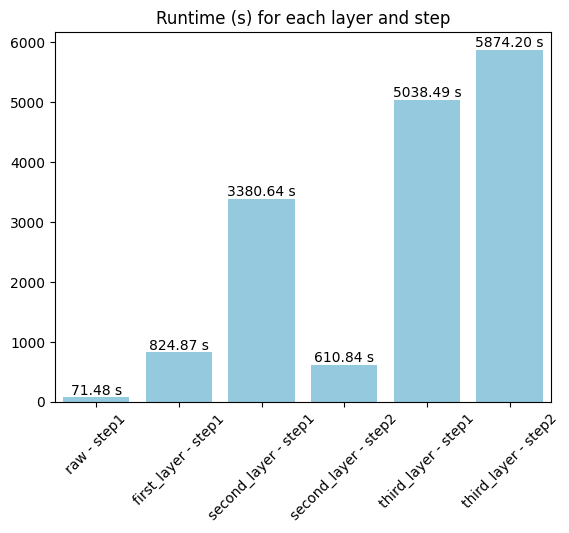

In [ ]:
runtimes = get_details(key='runtime')
sns.barplot(x=list(runtimes.keys()), y=list(runtimes.values()), color='skyblue')
for i, v in enumerate(runtimes.values()):
    plt.text(i, v, f'{v:.2f} s', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title('Runtime (s) for each layer and step')
plt.show()

Dapat dilihat di atas bahwa durasi eksekusi dari setiap layer cukup bervariasi, dengan cenderung naik untuk setiap tingkatan layernya. Layer 1 membutuhkan waktu eksekusi yang paling singkat, diikuti oleh Layer 2 dan Layer 3. Hal ini dapat disebabkan oleh kompleksitas proses feature engineering yang semakin meningkat pada setiap layer, sehingga membutuhkan waktu eksekusi yang lebih lama. Penurunan pada durasi eksekusi pada **second layer - step 2** terjadi karena adanya proses seleksi fitur menggunakan metode RFE. Proses ini mengurangi jumlah fitur yang digunakan dalam model, sehingga mempercepat waktu eksekusi.

Setelah itu, mari kita lihat analisis terhadap skor akurasi dari setiap layer yang telah diimplementasikan. Skor akurasi ini mencakup nilai akurasi dari model yang dihasilkan pada setiap layer. Berikut adalah visualisasi skor akurasi dari setiap layer:

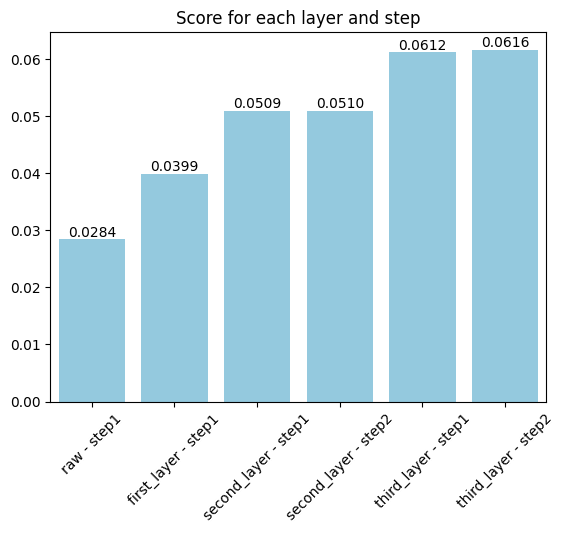

In [ ]:
best_score = get_details('best_score')
sns.barplot(x=list(best_score.keys()), y=list(best_score.values()), color='skyblue')
for i, v in enumerate(best_score.values()):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title('Score for each layer and step')
plt.show()

Berdasarkan plot di atas, dapat dilihat bahwa skor akurasi dari setiap layer terus naik untuk setiap tahapannya. Mulai dari yang raw data di Layer 1, hingga setelah dilakukan feature engineering di Layer 2 dan Layer 3. Hal ini menunjukkan bahwa proses feature engineering yang dilakukan pada setiap layer berhasil meningkatkan kualitas model, sehingga menghasilkan skor akurasi yang semakin tinggi.

Pada **second layer - step 2** dan **third layer - step 2**, nilai skor naik tetapi tidak signifikan (cukup stagnan). Hal ini dapat disebabkan oleh proses seleksi fitur yang dilakukan pada kedua layer tersebut. Proses seleksi fitur ini berarti dapat meningkatkan kualitas model dengan mengurangi fitur yang tidak penting, meskipun tidak selalu berdampak signifikan pada skor akurasi.

Selanjutnya, kita akan melihat bagaimana persebaran feature importance dari setiap layer yang telah diimplementasikan. Feature importance ini mencakup nilai penting dari setiap fitur yang digunakan dalam model. Berikut adalah visualisasi feature importance dari setiap layer:

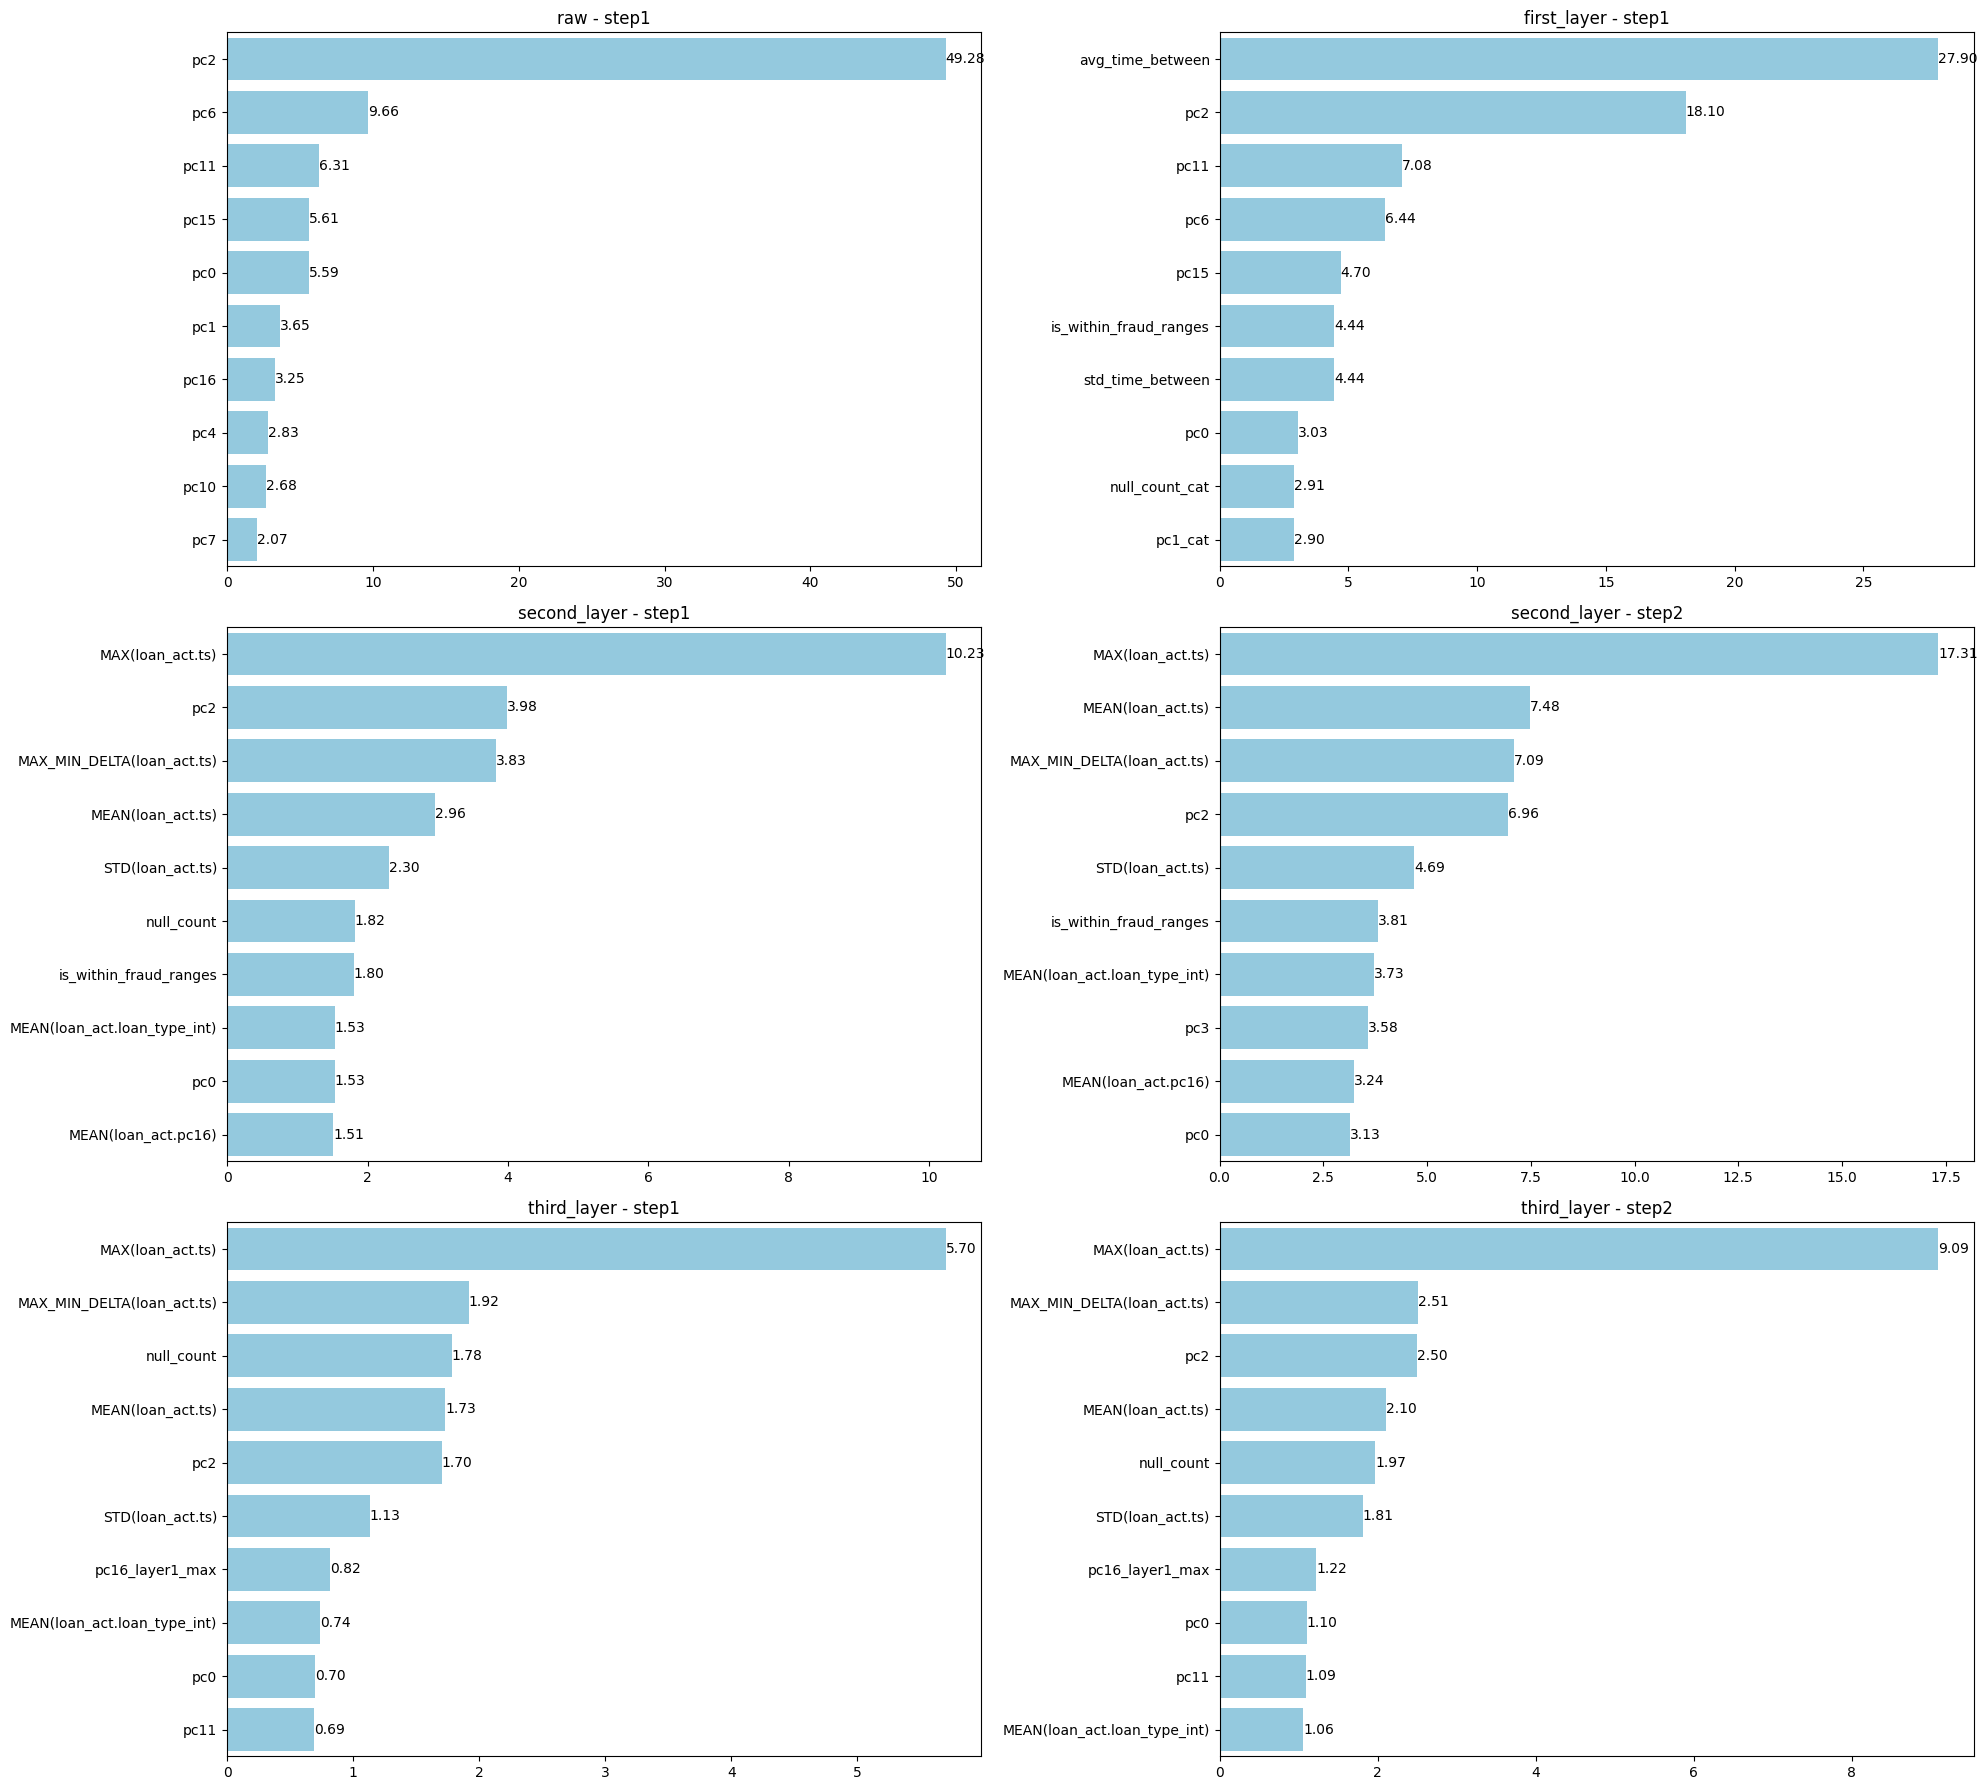

In [ ]:
FI = get_details(key='feature_importances', null={})
num_plots = len(FI)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 6 * num_rows))
axes = axes.flatten()

for ax, (k, v) in zip(axes, FI.items()):
    sns.barplot(ax=ax, x=[x[1] for x in sorted(v.items(), key=lambda x: -x[1])[:10]], 
                y=[x[0] for x in sorted(v.items(), key=lambda x: -x[1])[:10]], 
                color='skyblue')
    for i, (value, name) in enumerate(zip([x[1] for x in sorted(v.items(), key=lambda x: -x[1])[:10]], 
                                          [x[0] for x in sorted(v.items(), key=lambda x: -x[1])[:10]])):
        ax.text(value, i, f'{value:.2f}', ha='left', va='center')
    ax.set_title(k)

for ax in axes[num_plots:]:
    ax.remove()

plt.tight_layout()
plt.show()

Visualisasi di atas menunjukkan bagaimana feature importance untuk setiap layer yang telah diimplementasikan. 
- Pada tahap awal di raw, naive fitur `pc2`, `pc11`, dan `pc6` muncul sebagai yang paling signifikan. 
- Selanjutnya, pada layer dan step berikutnya, dilakukan feature engineering yang menghasilkan fitur baru seperti 1null_count`, `avg_time_between`, dan `MAX(loan_act.ts)`. Ketiga fitur ini muncul sebagai fitur yang cukup penting untuk model.
- Pada layer ketiga yang merupakan hasil dari feature engineering menggunakan metode BFS, fitur-fitur yang dihasilkan seperti `MAX(loan_act.ts)` dan `MAX_MIN_DELTA(loan_act.ts)` tetap menjadi fitur yang penting untuk model. Meskipun beberapa fitur hasil layer ini juga muncul seperti `pc16_layer_max`.

Lagi-lagi, dengan hasil ini cukup menunjukkan bahwa proses feature engineering yang dilakukan berhasil meningkatkan kualitas model dengan menambahkan fitur-fitur baru yang penting.

## 6.2 Analisis Hasil Model Akhir

### 6.2.1 Calibration Curve

Kurva kalibrasi menunjukkan seberapa baik probabilitas prediksi dari model XGBClassifier sesuai dengan probabilitas sebenarnya. Garis diagonal oranye mewakili kalibrasi sempurna, sementara garis biru menunjukkan performa model. Titik-titik pada garis biru di bawah garis oranye mengindikasikan bahwa model mengunderestimate probabilitas kejadian, sedangkan titik-titik di atas garis oranye menunjukkan overestimate. Pada grafik ini, model XGBClassifier tampak kurang baik dalam kalibrasi, terutama pada probabilitas tinggi yang menunjukkan ketidakstabilan

Berdasarkan grafik, dapat dilihat bahwa model XGB cenderung lebih konservatif dalam membuat prediksi, dan juga memiliki kelemahan dalam memprediksi label dengan probabilitas tinggi fraud.

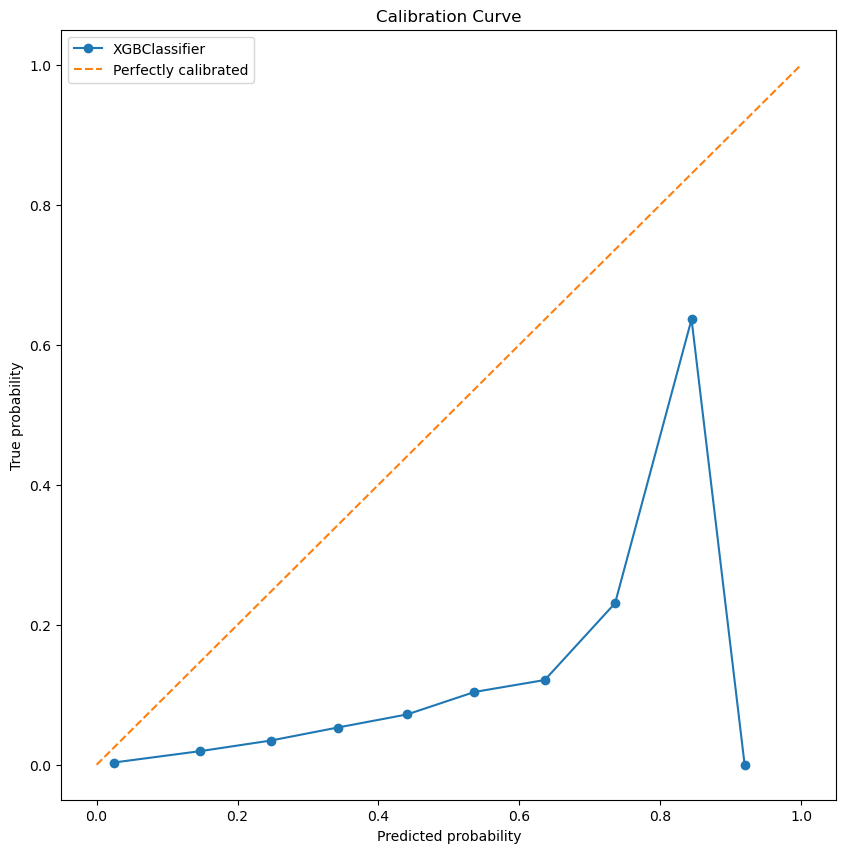

In [ ]:
# from sklearn.calibration import calibration_curve
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import copy

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1001)

# model = copy.deepcopy(best_estimator)
# model.fit(X_train, y_train)

# y_prob = model.predict_proba(X_test)[:, 1]

# prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# plt.figure(figsize=(10, 10))
# plt.plot(prob_pred, prob_true, marker='o', label='XGBClassifier')
# plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
# plt.xlabel('Predicted probability')
# plt.ylabel('True probability')
# plt.title('Calibration Curve')
# plt.legend()
# plt.show()

### 6.2.2 SHAP

Grafik SHAP (SHapley Additive exPlanations) di atas menampilkan pengaruh masing-masing fitur terhadap output model, dengan fitur yang paling berpengaruh ditempatkan di bagian atas. Setiap titik menunjukkan nilai SHAP dari satu fitur untuk satu sampel data, dengan warna yang menunjukkan nilai fitur (merah untuk nilai tinggi, biru untuk nilai rendah). Misalnya, fitur "MAX(loan_act.ts)" memiliki nilai SHAP yang tinggi dan positif, menunjukkan bahwa nilai tinggi dari fitur ini cenderung meningkatkan output model. Sebaliknya, fitur "is_within_fraud_ranges" secara konsisten memiliki nilai SHAP negatif, hal tersebut karena kolom ini digunakan untuk mengkonfirmasi apakah layak dianggap fraud, jadi jika nilainya rendah, maka bisa lebih pasti bahwa bukan fraud, dan SHAP menunjukkan itu menurunkan probabilitas fraud dengan condongnya ke kiri.

In [ ]:
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

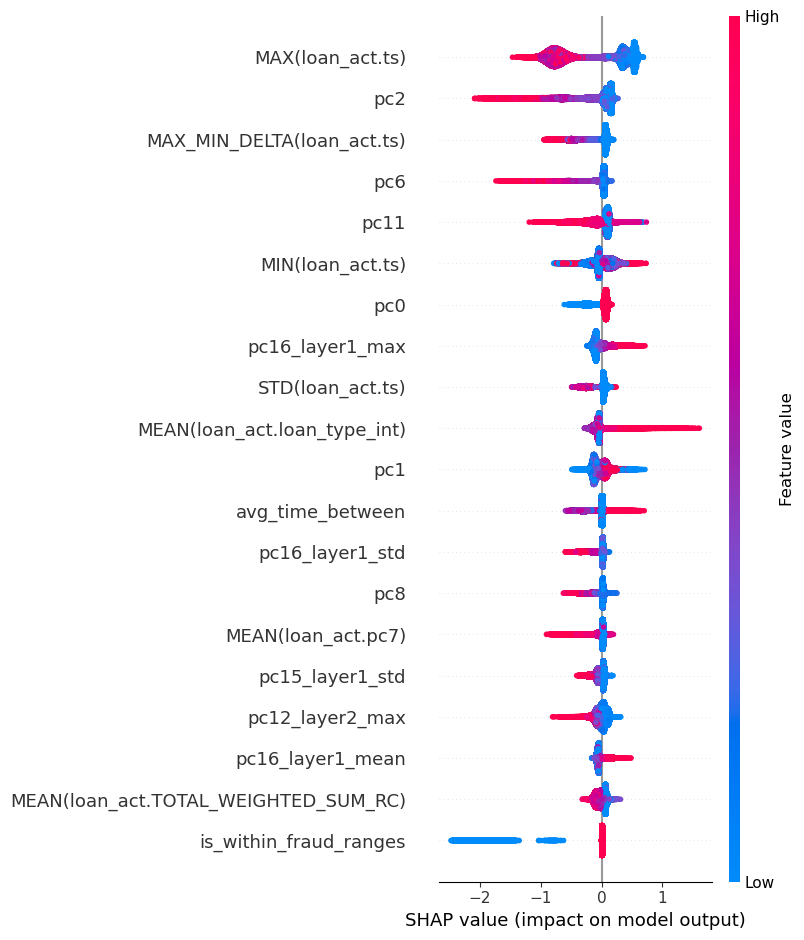

In [ ]:
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

### 6.2.3 Confusion Matrix

Hasil confusion matrix ini menunjukkan performa model dalam mendeteksi fraud (Class 1) dan non-fraud (Class 0). Dari 170,583 instance yang sebenarnya tidak fraud (Class 0), model berhasil mengklasifikasikan 168,505 instance dengan benar sebagai non-fraud dan salah mengklasifikasikan 881 instance sebagai fraud (false positives). Untuk 2,194 instance yang sebenarnya fraud (Class 1), model berhasil mengidentifikasi 117 instance dengan benar sebagai fraud dan gagal mendeteksi 2,077 instance sebagai fraud (false negatives). Tingginya jumlah false negatives menunjukkan bahwa model kesulitan dalam mendeteksi kasus fraud, yang merupakan area penting untuk ditingkatkan agar lebih efektif dalam aplikasi nyata.

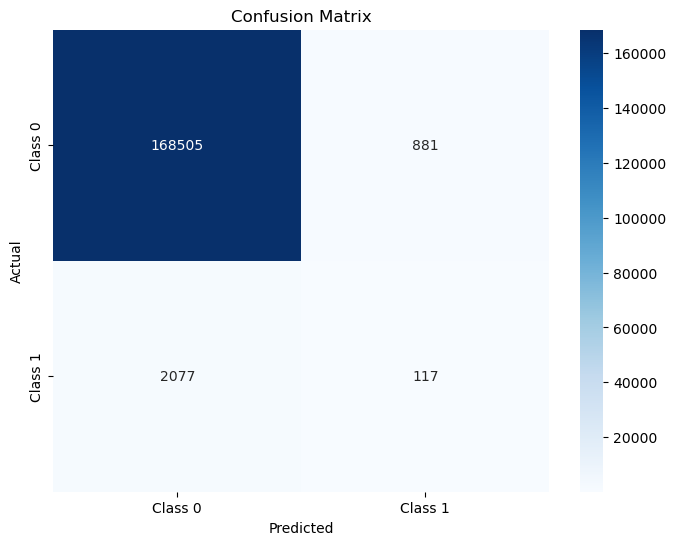

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# y_pred = model.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

### 6.2.4 ICE and PDP representation

Gambar di bawah menunjukkan representasi ICE (Individual Conditional Expectation) dan PDP (Partial Dependence Plot) untuk dua fitur. Garis biru muda pada kedua plot menunjukkan kurva ICE untuk masing-masing instance dalam data, yang menggambarkan bagaimana prediksi model berubah ketika nilai satu fitur tertentu bervariasi, sementara fitur lainnya tetap konstan. Garis putus-putus oranye mewakili PDP, yang menunjukkan efek rata-rata dari perubahan fitur tersebut terhadap prediksi model. Dari plot ini, terlihat bahwa untuk kedua fitur, peningkatan nilai cenderung menurunkan prediksi model secara konsisten. PDP memberikan gambaran umum tentang hubungan fitur dengan output model, sedangkan ICE menunjukkan variasi di antara individu-individu dalam data.

Dari grafik-grafik ICE Plot, 6 feature dengan importance terbesar sudah cukup bagus dengan menggambarkan penambahan/penurunan probabilitas (ditandai dengan naik/turun ke satu sisi).

Computing partial dependence plots and individual conditional expectation...
done in 32.533s
Computing partial dependence plots and individual conditional expectation...
done in 30.948s
Computing partial dependence plots and individual conditional expectation...
done in 31.191s


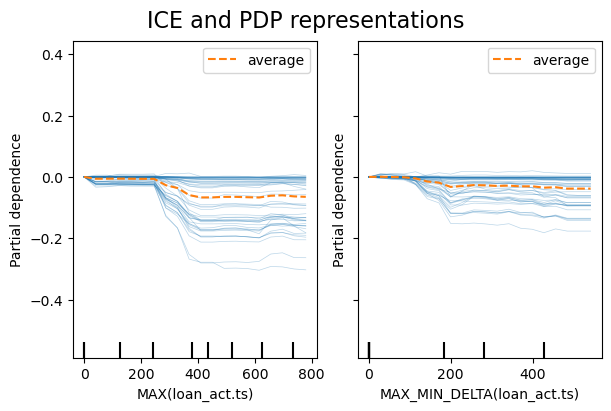

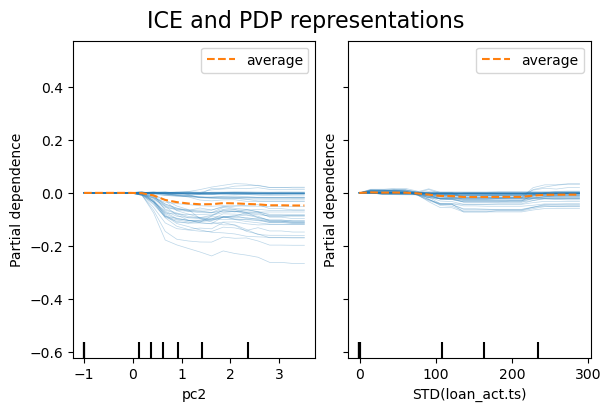

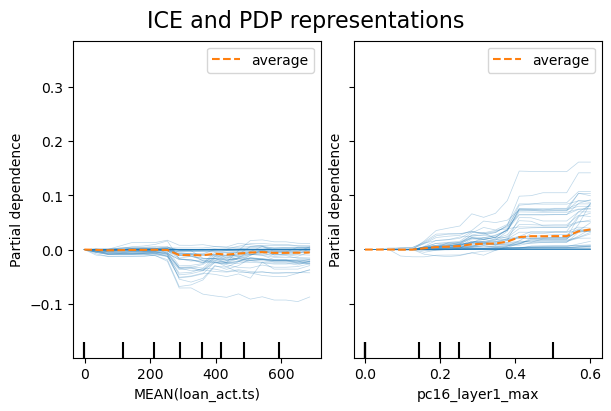

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.inspection import PartialDependenceDisplay
# from time import time

# def plot_partial_dependence(model, X_train, features):
#     """
#     Plots partial dependence and individual conditional expectation for given features.

#     Parameters:
#     model: The trained model.
#     X_train: The training data.
#     features: List of features to plot.
#     """
#     print("Computing partial dependence plots and individual conditional expectation...")
#     tic = time()
#     _, ax = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

#     common_params = {
#         "subsample": 50,
#         "n_jobs": 2,
#         "grid_resolution": 20,
#         "random_state": 0,
#     }

#     features_info = {
#         "features": features,
#         "kind": "both",
#         "centered": True,
#     }

#     display = PartialDependenceDisplay.from_estimator(
#         model,
#         X_train,
#         **features_info,
#         ax=ax,
#         **common_params,
#     )
#     print(f"done in {time() - tic:.3f}s")
#     _ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

# plot_partial_dependence(model, X_train, ["MAX(loan_act.ts)", "MAX_MIN_DELTA(loan_act.ts)"])
# plot_partial_dependence(model, X_train, ["pc2", "STD(loan_act.ts)"])
# plot_partial_dependence(model, X_train, ["MEAN(loan_act.ts)", "pc16_layer1_max"])

# 7. Kesimpulan
Kembali ke [Daftar Isi](#Daftar-Isi)

Sebagai kesimpulan, kami telah melakukan analisis mendalam terhadap data yang diberikan, melakukan feature engineering dengan memanfaatkan paradigma data tabular dan graph, serta mengembangkan model XGBoost untuk deteksi fraud. Berikut adalah beberapa poin penting yang dapat diambil dari proyek ini:
- *Pola Label dan Fitur*: Dari hasil EDA, terlihat bahwa terdapat perbedaan distribusi data antara kelas 0: Non-Fraud dan kelas 1: Fraud. Hal ini menunjukkan pentingnya fitur-fitur yang ada dalam membedakan nilai label. Selain itu, terdapat nilai outlier yang cukup ekstrem yang dapat mempengaruhi kinerja model.

- *Pentingnya Feature Engineering*: Proses feature engineering yang dilakukan berhasil meningkatkan kualitas model dengan menambahkan fitur-fitur baru yang penting. Dengan memanfaatkan metode DFS dan BFS, kami berhasil membuat fitur-fitur baru yang dapat meningkatkan akurasi model.
    - *Paradigma Data Tabular*: Pada layer 1 dan 2, kami menggunakan metode DFS untuk membuat fitur baru dengan mengagregasi nilai berdasarkan user_id dan reference_contact. Fitur-fitur ini membantu model dalam memahami pola data dan meningkatkan akurasi prediksi.
    - *Paradigma Data Graph*: Pada layer 3, kami menggunakan metode BFS untuk mengagregasi nilai fitur pada setiap node adjacent yang berada di distance 1 dan 2. Dengan memanfaatkan fitur naive dan fitur baru yang dihasilkan, kami berhasil membuat fitur baru yang penting untuk model.

- *Seleksi Fitur*: Proses seleksi fitur menggunakan metode RFE berhasil mengurangi jumlah fitur yang tidak penting, sehingga mempercepat waktu eksekusi dan meningkatkan kualitas model. Seleksi fitur ini penting untuk memastikan bahwa model hanya menggunakan fitur-fitur yang penting dalam membuat prediksi.

- *Penggunaan Model XGBoost*: Model XGBoost dipilih karena kemampuannya dalam menangkap pola kompleks, memperbaiki kesalahan secara iteratif, dan memberikan penjelasan yang jelas dari prediksi model. Dengan menggunakan XGBoost, kami berhasil mengembangkan model yang akurat dan andal untuk deteksi fraud.

- *Analisis Hasil*: Analisis hasil model menunjukkan bahwa model yang dikembangkan memiliki kualitas yang baik, dengan nilai akurasi yang tinggi dan kemampuan untuk menjelaskan prediksi yang dihasilkan. Dengan menggunakan calibration curve, SHAP, confusion matrix, ICE, dan PDP, kami dapat memahami lebih dalam bagaimana model bekerja dan bagaimana model dapat digunakan untuk deteksi fraud.